In [1]:
import sys
import os
import timeit

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
#from dmd_machine.dmd_ae_machine import DMDMachine
#from dmd_machine.loss_function import LossFunction
#from data.Data import DataMaker
from datetime import date
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
#from return_stats import *
#from create_plots import *
from tensorflow import keras
from datetime import date
import pickle
import joblib
import time

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline
print(os.getcwd())

C:\Users\Chuanhua\ROM-DMD-LSTM


In [2]:
#Split the data into two parts for training and prediction validation
import math
import joblib
training_data_whole = joblib.load(open('./data/case2data/original_data.pkl', 'rb'))
print(training_data_whole.shape)

two_dimension_data_0=training_data_whole.reshape(training_data_whole.shape[0],training_data_whole.shape[1]*2)[0:1601]
two_dimension_data=training_data_whole.reshape(training_data_whole.shape[0],training_data_whole.shape[1]*2)[1601:2001]

print(two_dimension_data_0.shape)
print(two_dimension_data.shape)

print(two_dimension_data_0[1600,1000:1010])
print(two_dimension_data[0,1000:1010])

(2001, 55268, 2)
(1601, 110536)
(400, 110536)
[0.86872564 0.89846041 0.87159115 0.89381653 0.87432836 0.86271523
 0.87694261 0.83293543 0.87943917 0.80446998]
[0.80080081 0.88117396 0.80510841 0.87867965 0.80925831 0.85010617
 0.81325714 0.82269811 0.81711006 0.79644982]


In [3]:
#Using the POD to study the code length correspoonding with percentage of energy captured
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90, svd_solver='full')
pca.fit(two_dimension_data_0)
print(pca.explained_variance_ratio_)
pca_data=pca.transform(two_dimension_data_0)
print(pca_data.shape)

[0.3785023  0.26103692 0.19093161 0.02598685 0.02164349 0.01830285
 0.01618016]
(1601, 7)


/home/chuanhua/Experiments/ROM_LSTM
time spend for reduction: 13.686517128007836
Reconstruction Error (Normalized Frobenius Norm): 0.1065
time spend for reduction: 16.024331943001016
Reconstruction Error (Normalized Frobenius Norm): 0.0775
time spend for reduction: 18.34546412700729
Reconstruction Error (Normalized Frobenius Norm): 0.0355


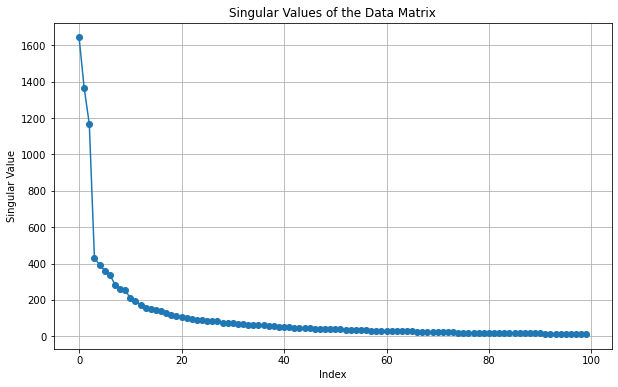

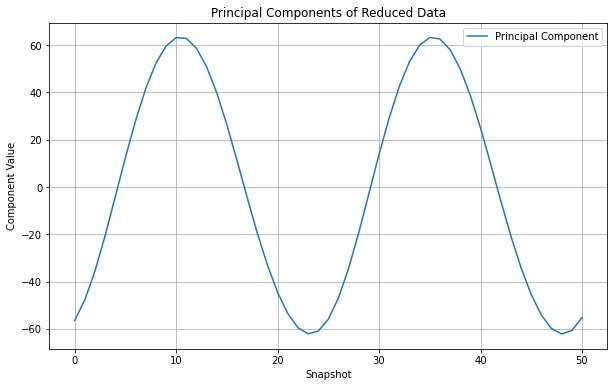

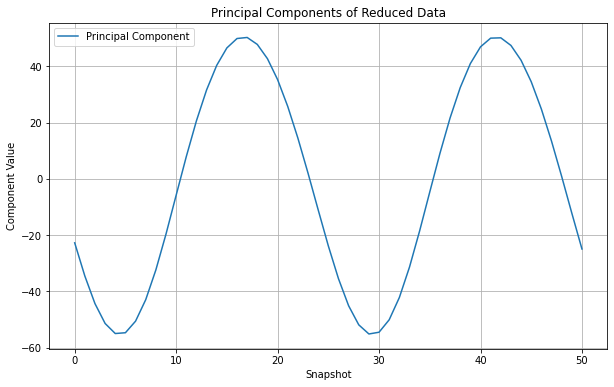

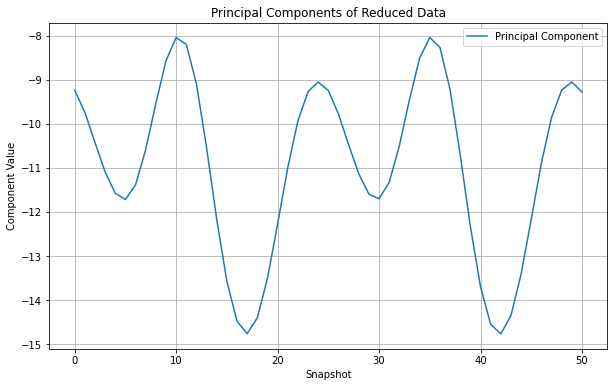

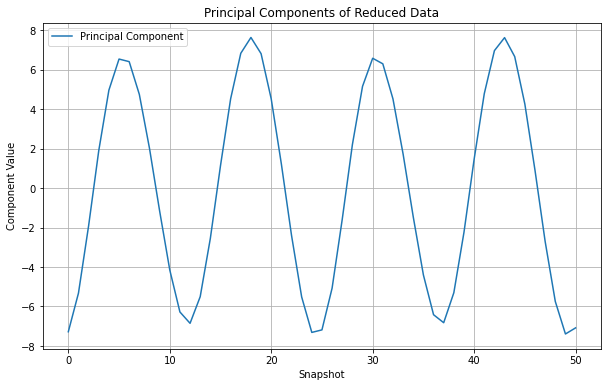

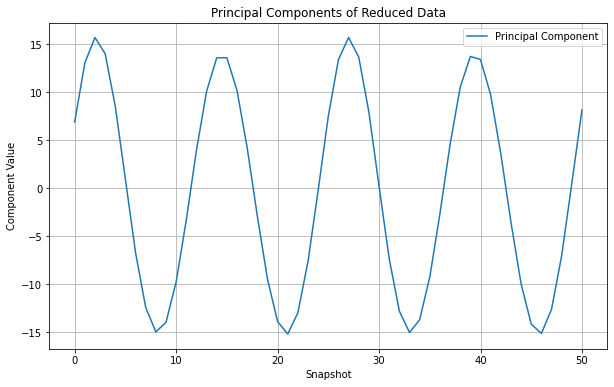

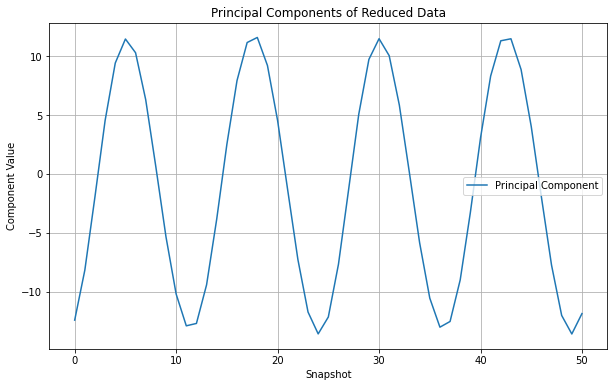

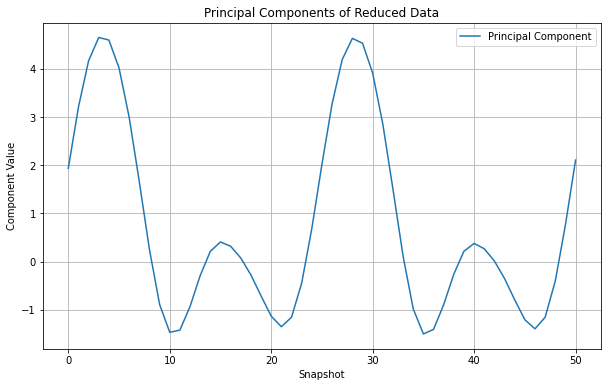

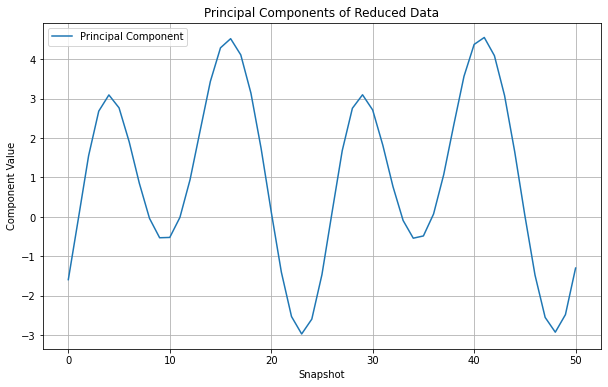

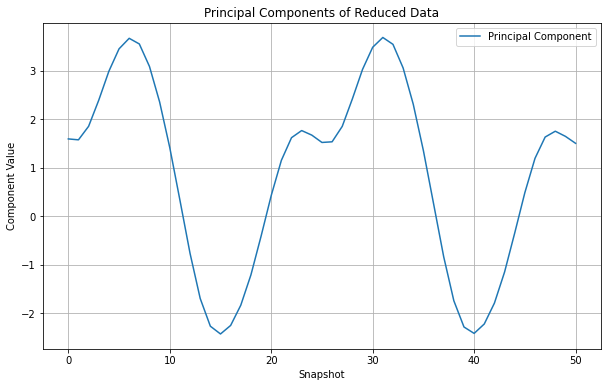

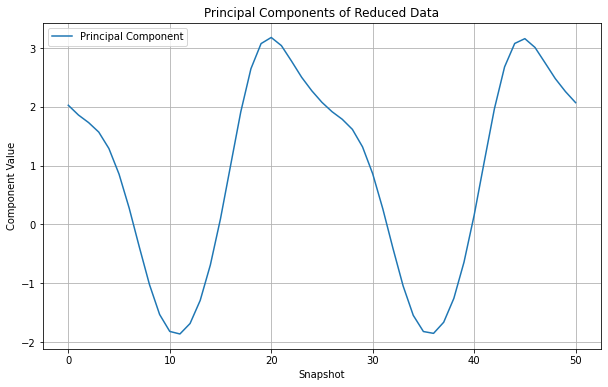

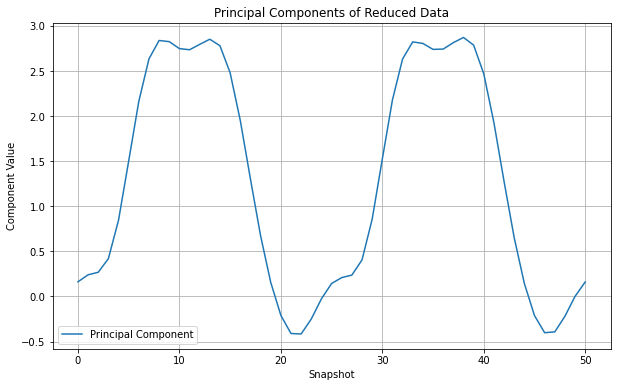

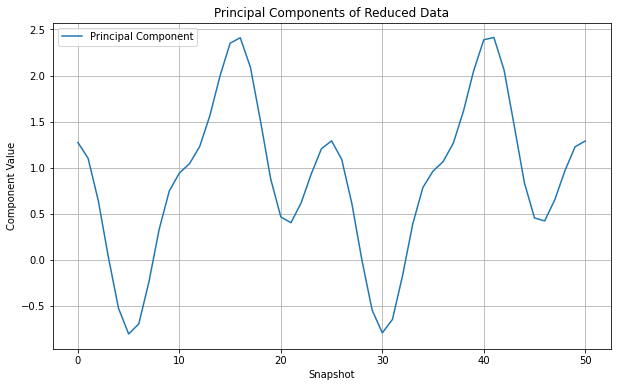

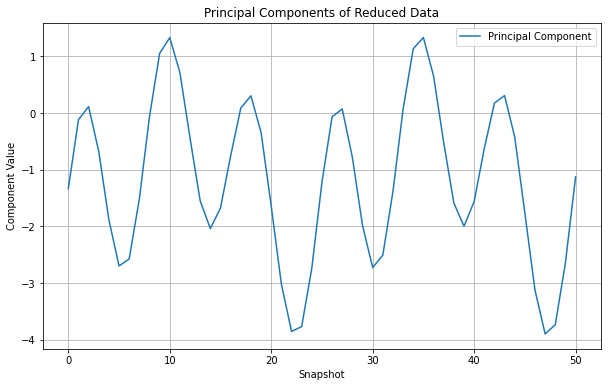

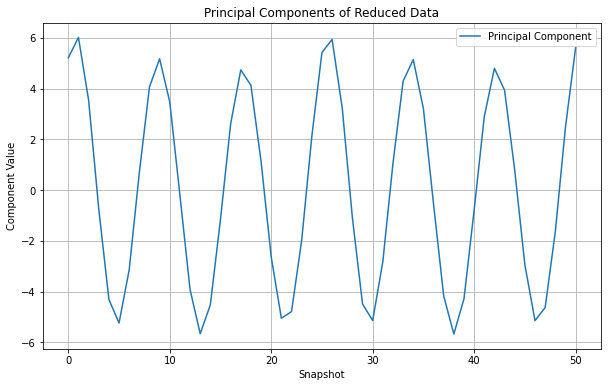

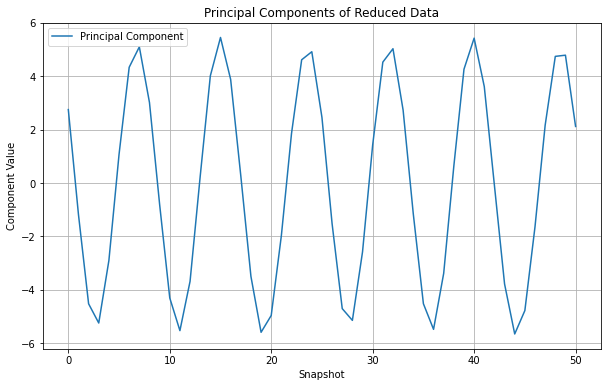

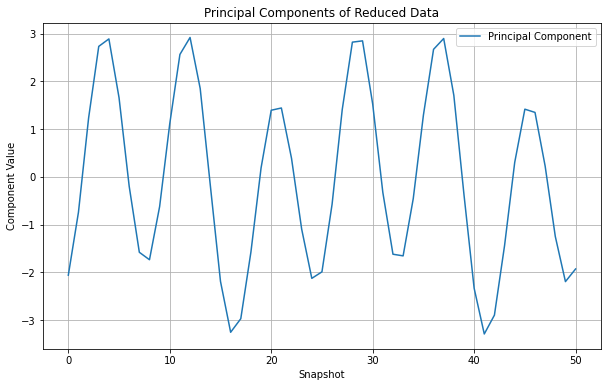

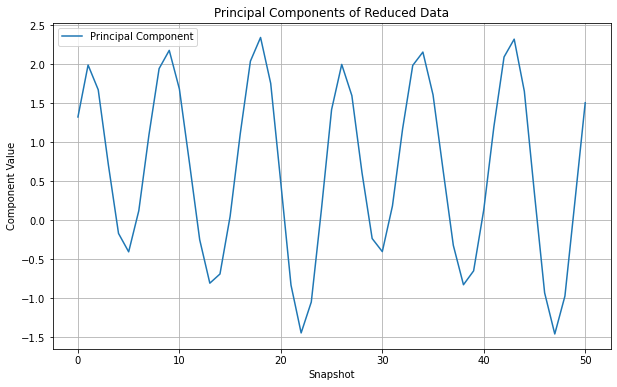

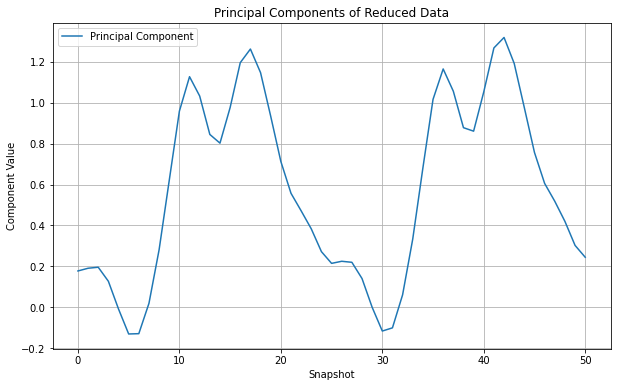

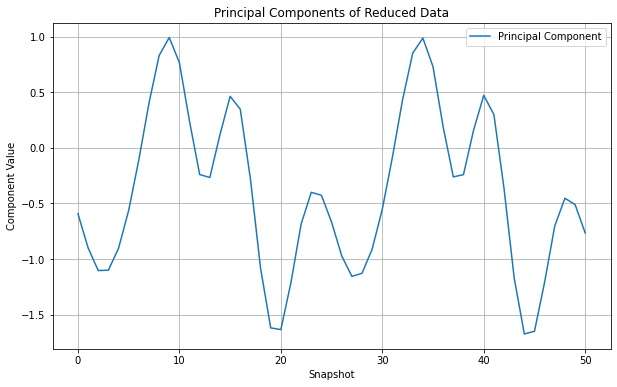

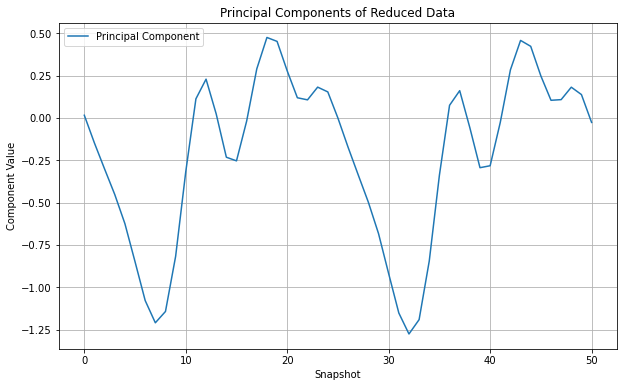

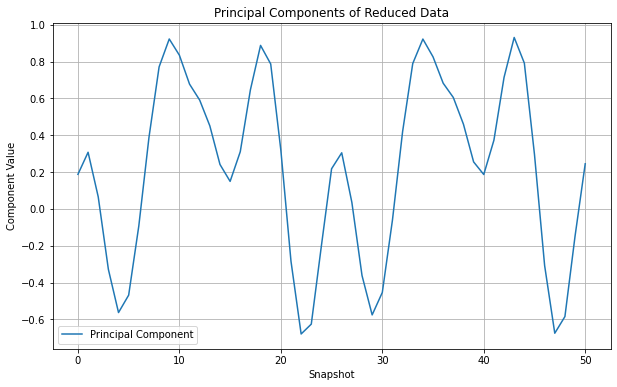

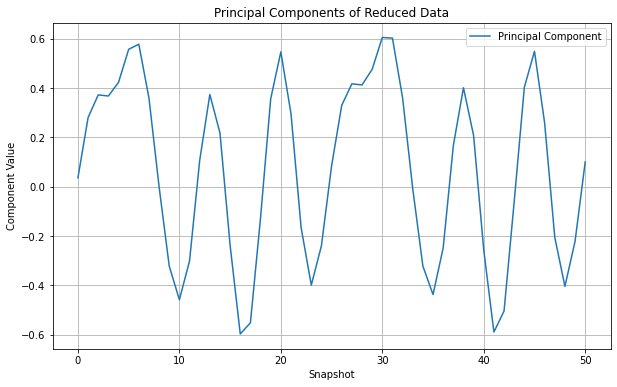

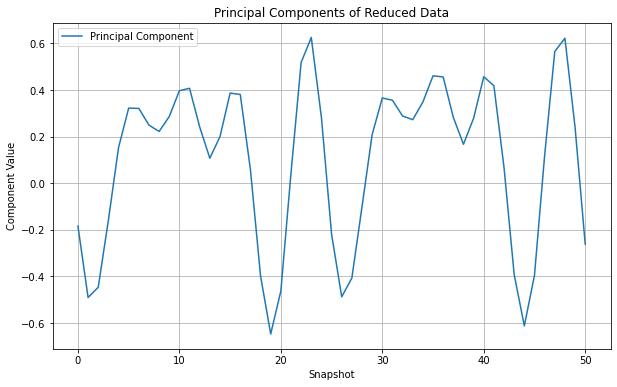

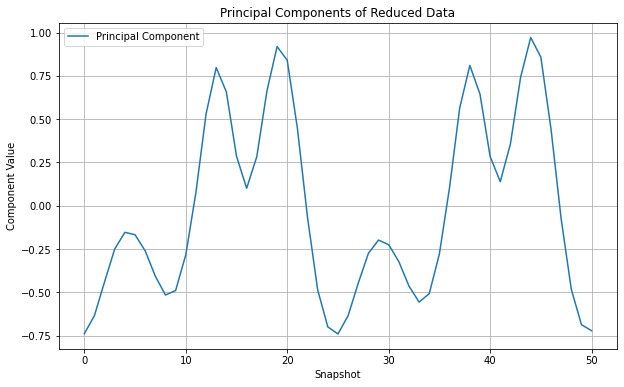

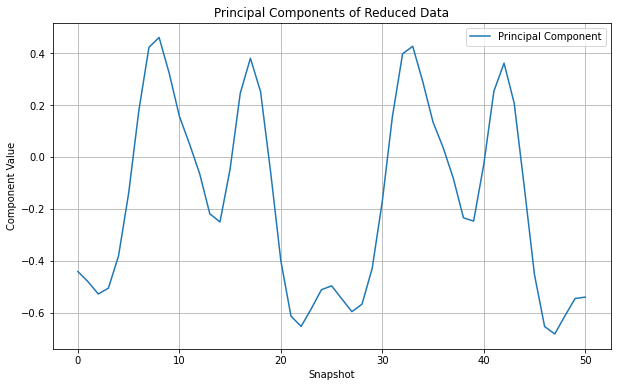

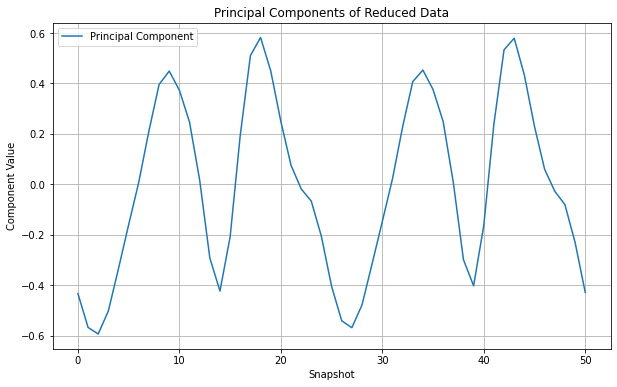

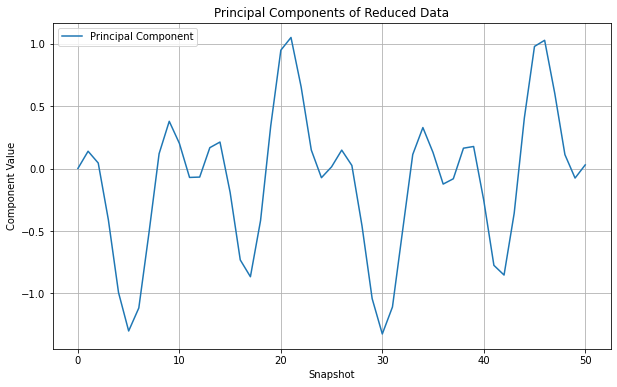

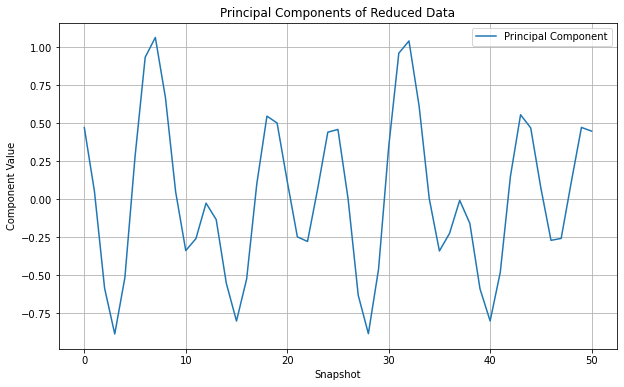

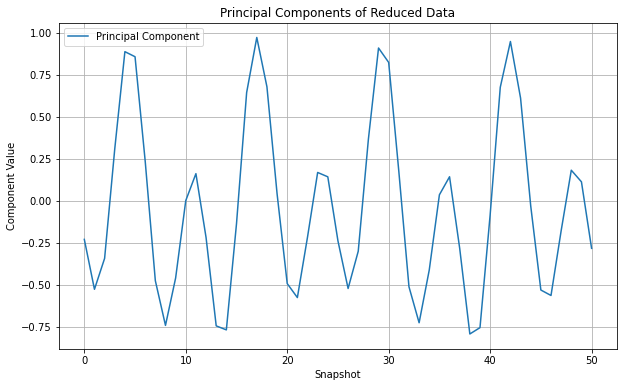

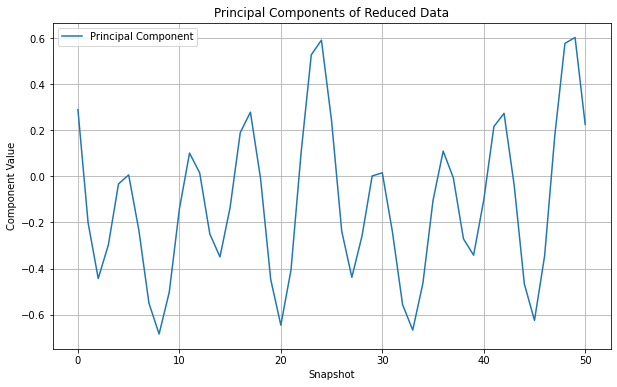

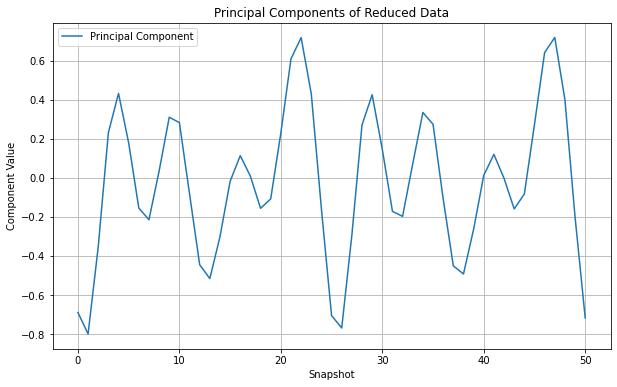

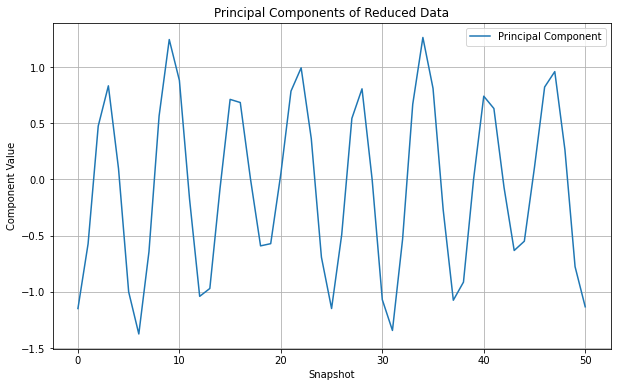

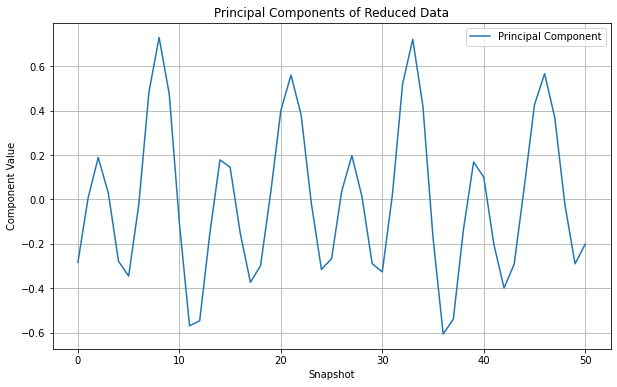

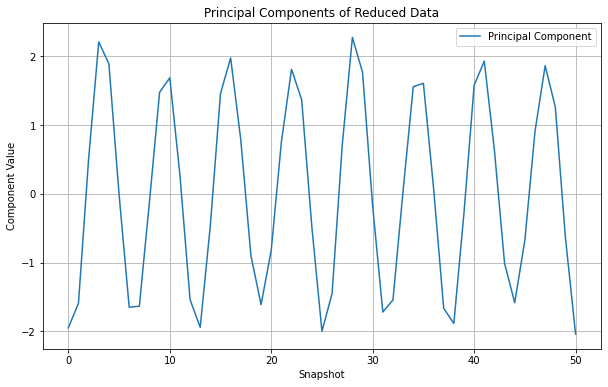

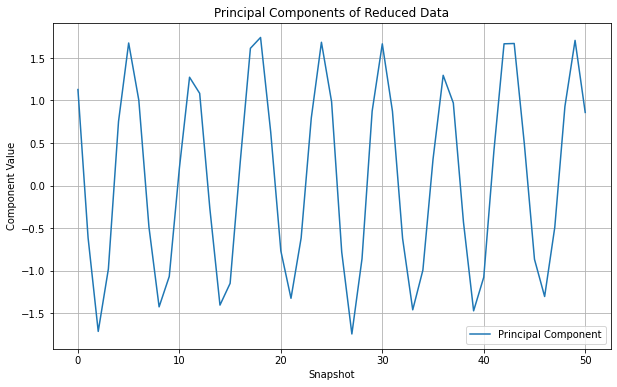

In [138]:
#POD model for comparison with SAE to display the effectiveness of SAE in order reduce.
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pickle
import joblib

import os
print(os.getcwd()) 

# Step 1: Prepare the Data
data = two_dimension_data_0  # Replace this with your actual data


#start time
start_time=timeit.default_timer()
# Step 2: Compute the Mean
mean_data = np.mean(data, axis=0)  # Mean of each column (feature)

# Step 3: Center the Data
data_centered = data - mean_data

# Step 4: Compute the Covariance Matrix
# Note: In practice, for large data, we often use a different method to compute the SVD directly.
U, S, Vt = np.linalg.svd(data_centered, full_matrices=False)

# U is (1600, 1600), S is (1600,), Vt is (1600, 110536)

# Step 5: Compute POD Modes (Principal Components)
# Vt.T gives the right singular vectors, which are the principal directions
# Let's select the top k components

k_collection = [7,12,35]  # Number of principal components to keep (hyperparameter, change as needed)
for k in k_collection:
    POD_modes = Vt[:k, :]  # Top k POD modes

    # Step 6: Project the Data onto the Reduced Dimensional Space
    # This gives us the reduced data representation in the lower-dimensional space
    data_reduced = np.dot(data_centered, POD_modes.T)
    pickle.dump(data_reduced, open("./Temp_data_Case2/reduced_data_" + str(k) + "_POD.pkl", "wb"))

    #end time
    end_time=timeit.default_timer()
    print("time spend for reduction:",end_time - start_time)

    # Step 7: Reconstruct the Data (Optional, to evaluate effectiveness)
    # This is done by projecting back to the original space
    data_reconstructed = np.dot(data_reduced, POD_modes) + mean_data
    pickle.dump(data_reconstructed, open("./Temp_data_Case2/reconstructed_data_" + str(k) + "_POD.pkl", "wb"))

    # Step 8: Evaluate Reconstruction Error (Optional)
    reconstruction_error = np.linalg.norm(data - data_reconstructed) / np.linalg.norm(data)
    print(f"Reconstruction Error (Normalized Frobenius Norm): {reconstruction_error:.4f}")

# Step 9: Visualize the Singular Values (Optional)
plt.figure(figsize=(10, 6))
plt.plot(S[:100], marker='o')
plt.title('Singular Values of the Data Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Step 10: Visualize the Data Reduction (Optional)
# You can plot the reduced data or the reconstruction error if needed
data_reduced = joblib.load(open("./Temp_data_Case2/reduced_data_" + str(k) + "_POD.pkl",'rb'))
for idx in range(data_reduced.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(data_reduced[1550:, idx], label='Principal Component')
    plt.title('Principal Components of Reduced Data')
    plt.xlabel('Snapshot')
    plt.ylabel('Component Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# ***SAE Model***

In [3]:
#The python code of the stacked autoencoder model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Lambda,
    Dropout,
    Flatten,
    Reshape,
    Conv2DTranspose,
)
from tensorflow.keras.models import load_model, Sequential, Model
class StackAutoencoder(object):
	"""docstring for Stack_Autoencoder"""
	def __init__(self):
		super(StackAutoencoder, self).__init__()


	def save_model(self, model, model_name, save_dir):
	# function for saving model

		if not os.path.isdir(save_dir):
			os.makedirs(save_dir)
		model_path = os.path.join(save_dir, model_name)
		model.save(model_path)


	def encoder_model(self, input_dim, encoding_dim):

		#encoded = Dense(encoding_dim * 32, activation='relu')(input_dim)
		#encoded = Dense(encoding_dim * 16, activation='relu')(encoded)
		#encoded = Dense(encoding_dim * 8, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 8, activation='relu')(input_dim)
		encoded = Dense(encoding_dim * 4, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
		code = Dense(encoding_dim)(encoded)

		return code

	def decoder_model(self, vtu_data, code, encoding_dim):

		decoded = Dense(encoding_dim * 2, activation='relu')(code)
		decoded = Dense(encoding_dim * 4, activation='relu')(decoded)
		decoded = Dense(encoding_dim * 8, activation='relu')(decoded)
		#decoded = Dense(encoding_dim * 16, activation='relu')(decoded)
		#decoded = Dense(encoding_dim * 32, activation='relu')(decoded)
		decoded = Dense(vtu_data.shape[1], activation='sigmoid')(decoded)

		return decoded


	def load_model(self, vtu_data, encoding_dim):

		input_dim = Input(shape=(vtu_data.shape[1]))
		encoder_output = self.encoder_model(input_dim, encoding_dim)
		self.encoder = Model(inputs=input_dim, outputs=encoder_output, name='encoder') # from input to code
		# self.encoder.summary()


		# Create a encoder model 
		decoder_input = Input(shape=(encoding_dim)) #the input of the encoder 
		decoder_output = self.decoder_model(vtu_data, decoder_input, encoding_dim)
		self.decoder = Model(inputs=decoder_input, outputs=decoder_output, name="decoder")
		# self.decoder.summary()


		# connect the encoder and decoder model
		encoder_img = self.encoder(input_dim) # call the encoder model
		decoder_img = self.decoder(encoder_img) #call the decoder model
		self.autoencoder = Model(inputs=input_dim, outputs=decoder_img, name='autoencoder') #construct the autoencoder model

	def train_model(self, train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name):
		# def generate_arrays(x,batch_size):
		# 	while 1:
		# 		for idx in range(int(np.ceil(len(x)/batch_size))):
		# 			x_excerpt = x[idx*batch_size:(idx+1)*batch_size,...]
		# 			yield x_excerpt, x_excerpt


		check_model = ModelCheckpoint(model_save_folder + '/' + AE_file_name,
									monitor='val_loss',
									save_best_only=True,
									verbose=1)
		reduce_LR = ReduceLROnPlateau(monitor='val_loss',
									factor=0.5,
									patience=5,
									verbose=1,
									mode='min',
									min_delta=1e-10,
									cooldown=0,
									min_lr=0)

		# self.history_record = self.autoencoder.fit(generate_arrays(train, batch_size),
		# 													steps_per_epoch = np.ceil(len(train)/batch_size),
		# 													epochs = epochs,
		# 													callbacks=[check_model, reduce_LR],
		# 													# validation_split = 0.2)
		# 													validation_data=(validation, validation))
		self.history_record = self.autoencoder.fit(train, train,
                        epochs = epochs,
                        batch_size = batch_size,
                        callbacks=[check_model, reduce_LR],
                        validation_data=(validation, validation))

		# draw_Acc_Loss(self.history_record)
		self.save_model(self.encoder, encoder_file_name, model_save_folder)
		self.save_model(self.decoder, decoder_file_name, model_save_folder)
		self.save_model(self.autoencoder, AE_file_name, model_save_folder)
		self.save_model(self.autoencoder, AE_file_name, model_save_folder)

		print(" DeepAE model trained successfully")

		scores = self.autoencoder.evaluate(test, test, batch_size, verbose=1)

		print('Test loss:', scores[0], '\nTest accuracy:', scores[1])

In [126]:
scaled_data=two_dimension_data_0
print(scaled_data.shape)
pred_time_steps=400

(1601, 110536)


# **Train AE model**

In [107]:
#Train the SAE model
from sklearn.model_selection import train_test_split

model_save_folder = './AE_Models_case2'

encoding_dim_array=[7,12,35]#90%,95%,99%
time_spending=[]
for encoding_dim in encoding_dim_array:    
    #start time
    start_time=timeit.default_timer()
    
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    
    batch_size = 32
    epochs = 300

    train_set, test = train_test_split(scaled_data, test_size=0.2, random_state=1)
    train, validation = train_test_split(train_set, test_size=0.1, random_state=2)
    print(train.shape)

    ae = StackAutoencoder()

    if os.path.exists(model_save_folder + "/" + AE_file_name):

        ae.autoencoder = load_model(model_save_folder + "/" + AE_file_name)
        ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
        ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()

        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)


    else:
        ae.load_model(train, encoding_dim)
        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()
        
        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)

    #end time
    end_time=timeit.default_timer()
    print("time spend for prediction:",end_time - start_time)
    time_spending.append(end_time - start_time)
print("time_spending",time_spending)

(1152, 110536)
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110536)]          0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 6192179   
_________________________________________________________________
decoder (Functional)         (None, 110536)            6302708   
Total params: 12,494,887
Trainable params: 12,494,887
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
36/36 [==============================] - 1s 34ms/step - loss: 0.0465 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.03844, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 2/300
36/36 [==========================

INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 25/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00

Epoch 00025: val_loss improved from 0.00305 to 0.00302, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 26/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00

Epoch 00026: val_loss improved from 0.00302 to 0.00293, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 27/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00

Epoch 00027: val_loss did not improve from 0.00293
Epoch 28/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0023 - accuracy:

INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 56/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0015 - accuracy: 8.6806e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00

Epoch 00056: val_loss improved from 0.00179 to 0.00167, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 57/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0015 - accuracy: 8.6806e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00

Epoch 00057: val_loss did not improve from 0.00167
Epoch 58/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0016 - accuracy: 8.6806e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00

Epoch 00058: val_loss did not improve from 0.00167
Epoch 59/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00

Epoch 00059: val_loss did not improve from 0.00167
Epoch


Epoch 00089: val_loss did not improve from 0.00142
Epoch 90/300
36/36 [==============================] - 1s 32ms/step - loss: 0.0012 - accuracy: 0.0104 - val_loss: 0.0015 - val_accuracy: 0.0000e+00

Epoch 00090: val_loss did not improve from 0.00142
Epoch 91/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.0069 - val_loss: 0.0014 - val_accuracy: 0.0000e+00

Epoch 00091: val_loss improved from 0.00142 to 0.00139, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 92/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.0174 - val_loss: 0.0014 - val_accuracy: 0.0000e+00

Epoch 00092: val_loss did not improve from 0.00139
Epoch 93/300
36/36 [==============================] - 1s 31ms/step - loss: 0.0012 - accuracy: 0.0061 - val_loss: 0.0014 - val_accuracy: 0.0000e+00

Epoch 00093: val_loss did not improve from 0.00139
Epoch 94/300
36/36 [=================

36/36 [==============================] - 1s 31ms/step - loss: 9.9733e-04 - accuracy: 0.0278 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00159: val_loss did not improve from 0.00125
Epoch 160/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9814e-04 - accuracy: 0.0260 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00160: val_loss did not improve from 0.00125
Epoch 161/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9708e-04 - accuracy: 0.0269 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00161: val_loss improved from 0.00125 to 0.00125, saving model to ./AE_Models_case3/AE_dim7
INFO:tensorflow:Assets written to: ./AE_Models_case3/AE_dim7/assets
Epoch 162/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9566e-04 - accuracy: 0.0269 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00162: val_loss did not improve from 0.00125
Epoch 163/300
36/36 [==============================] - 1s 32ms/step - loss: 9.9573e

36/36 [==============================] - 1s 31ms/step - loss: 9.8716e-04 - accuracy: 0.0269 - val_loss: 0.0013 - val_accuracy: 0.0000e+00

Epoch 00195: val_loss did not improve from 0.00125
Epoch 196/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8708e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00196: val_loss did not improve from 0.00125
Epoch 197/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8707e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00197: val_loss did not improve from 0.00125

Epoch 00197: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 198/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8693e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00198: val_loss did not improve from 0.00125
Epoch 199/300
36/36 [==============================] - 1s 32ms/step - loss: 9.8692e-04 - accuracy: 0.0269 - val_loss:

36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00269: val_loss did not improve from 0.00125
Epoch 270/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00270: val_loss did not improve from 0.00125
Epoch 271/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00271: val_loss did not improve from 0.00125
Epoch 272/300
36/36 [==============================] - 1s 32ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss: 0.0012 - val_accuracy: 0.0000e+00

Epoch 00272: val_loss did not improve from 0.00125

Epoch 00272: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
Epoch 273/300
36/36 [==============================] - 1s 31ms/step - loss: 9.8657e-04 - accuracy: 0.0269 - val_loss:

In [28]:
#call the SAE model for reconstruction
encoding_dim =35# [7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

y=ae.encoder(two_dimension_data_0)
print(y.shape)
x_ae=ae.decoder(y)
pickle.dump(x_ae, open("./Temp_data_Case2/reconstructed_data_" + str(encoding_dim) + "_SAE.pkl", "wb"))
print(x_ae.shape)
print(x_ae[300,1010:1020])
print(two_dimension_data_0[300,1010:1020])

(1601, 35)
(1601, 110536)
tf.Tensor(
[0.958887   0.8720472  0.963397   0.84765697 0.96912766 0.8224552
 0.9669384  0.79814327 0.9659107  0.77840745], shape=(10,), dtype=float32)
[0.97073885 0.87779818 0.97336241 0.85091744 0.9760525  0.82482935
 0.97881786 0.79992286 0.98091136 0.77620991]


Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_324 (LSTM)              (None, 50)                11600     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 1, 50)             0         
_________________________________________________________________
lstm_325 (LSTM)              (None, 1, 50)             20200     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 1, 7)              357       
Total params: 32,157
Trainable params: 32,157
Non-trainable params: 0
_________________________________________________________________
(1601, 7)
lstm_inputs shape: (1600, 1, 7)
lstm_targets shape: (1600, 1, 7)
Epoch 1/500
48/48 [==============================] - 1s 4ms/step - loss: 14081.5479 - val_loss: 6321.8286
Epoch 2/500
48/48 [==============================] - 0s 1ms/step 

48/48 [==============================] - 0s 1ms/step - loss: 3.7092 - val_loss: 1.1091
Epoch 73/500
48/48 [==============================] - 0s 1ms/step - loss: 3.6366 - val_loss: 1.1122
Epoch 74/500
48/48 [==============================] - 0s 1ms/step - loss: 3.5862 - val_loss: 0.9731
Epoch 75/500
48/48 [==============================] - 0s 1ms/step - loss: 3.6252 - val_loss: 1.1333
Epoch 76/500
48/48 [==============================] - 0s 1ms/step - loss: 3.6839 - val_loss: 1.1083
Epoch 77/500
48/48 [==============================] - 0s 1ms/step - loss: 3.4795 - val_loss: 0.9011
Epoch 78/500
48/48 [==============================] - 0s 2ms/step - loss: 3.4345 - val_loss: 0.9967
Epoch 79/500
48/48 [==============================] - 0s 1ms/step - loss: 3.4264 - val_loss: 1.0570
Epoch 80/500
48/48 [==============================] - 0s 1ms/step - loss: 3.5763 - val_loss: 0.9915
Epoch 81/500
48/48 [==============================] - 0s 1ms/step - loss: 3.4393 - val_loss: 1.1655
Epoch 82/500


48/48 [==============================] - 0s 1ms/step - loss: 2.2672 - val_loss: 0.6297
Epoch 152/500
48/48 [==============================] - 0s 2ms/step - loss: 2.2604 - val_loss: 0.6250
Epoch 153/500
48/48 [==============================] - 0s 1ms/step - loss: 2.2700 - val_loss: 0.6249
Epoch 154/500
48/48 [==============================] - 0s 2ms/step - loss: 2.2697 - val_loss: 0.6222
Epoch 155/500
48/48 [==============================] - 0s 1ms/step - loss: 2.2728 - val_loss: 0.6148
Epoch 156/500
48/48 [==============================] - 0s 1ms/step - loss: 2.2556 - val_loss: 0.6599
Epoch 157/500
48/48 [==============================] - 0s 2ms/step - loss: 2.2625 - val_loss: 0.6263
Epoch 158/500
48/48 [==============================] - 0s 1ms/step - loss: 2.2479 - val_loss: 0.6241
Epoch 159/500
48/48 [==============================] - 0s 1ms/step - loss: 2.2470 - val_loss: 0.7245

Epoch 00159: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 160/500
48/48 [===

48/48 [==============================] - 0s 2ms/step - loss: 2.1091 - val_loss: 0.5653
Epoch 230/500
48/48 [==============================] - 0s 2ms/step - loss: 2.1091 - val_loss: 0.5637
Epoch 231/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1063 - val_loss: 0.5653
Epoch 232/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1101 - val_loss: 0.5621
Epoch 233/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1091 - val_loss: 0.5676
Epoch 234/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1073 - val_loss: 0.5652
Epoch 235/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1076 - val_loss: 0.5619
Epoch 236/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1060 - val_loss: 0.5635
Epoch 237/500
48/48 [==============================] - 0s 1ms/step - loss: 2.1067 - val_loss: 0.5656
Epoch 238/500
48/48 [==============================] - 0s 2ms/step - loss: 2.1088 - val_loss: 0.5671
Epoc

Epoch 308/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0867 - val_loss: 0.5568
Epoch 309/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0864 - val_loss: 0.5571
Epoch 310/500
48/48 [==============================] - 0s 2ms/step - loss: 2.0862 - val_loss: 0.5576
Epoch 311/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0862 - val_loss: 0.5574
Epoch 312/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0864 - val_loss: 0.5570
Epoch 313/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0863 - val_loss: 0.5574
Epoch 314/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0861 - val_loss: 0.5572
Epoch 315/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0862 - val_loss: 0.5575
Epoch 316/500
48/48 [==============================] - 0s 2ms/step - loss: 2.0864 - val_loss: 0.5571

Epoch 00316: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 317

Epoch 458/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 459/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 460/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 461/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 462/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 463/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 464/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 465/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572
Epoch 466/500
48/48 [==============================] - 0s 1ms/step - loss: 2.0848 - val_loss: 0.5572

Epoch 00466: ReduceLROnPlateau reducing learning rate to 7.450580950807417e-12.
Epoch 467/

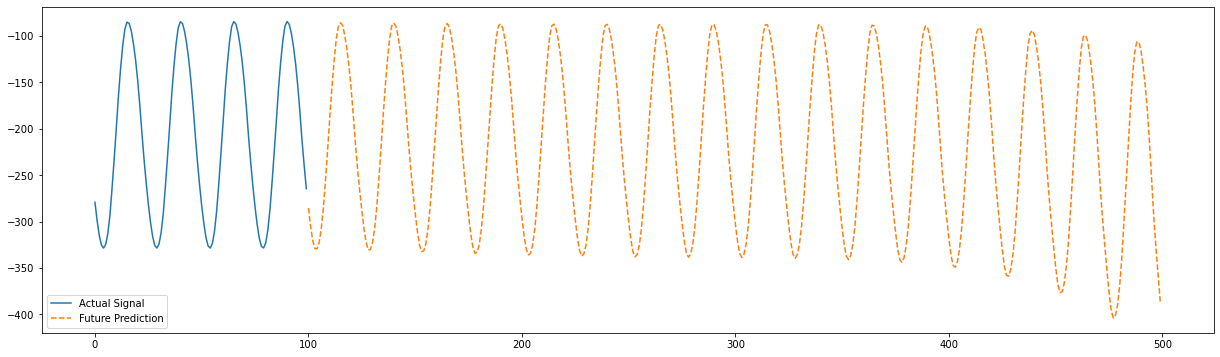

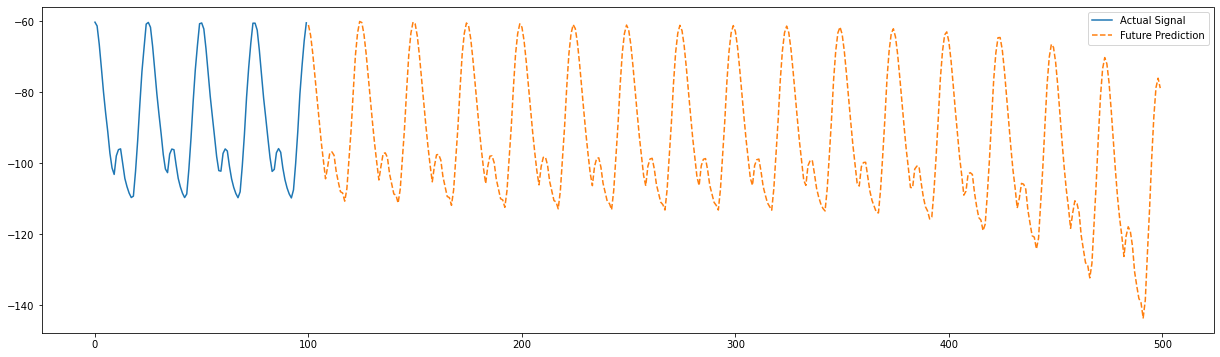

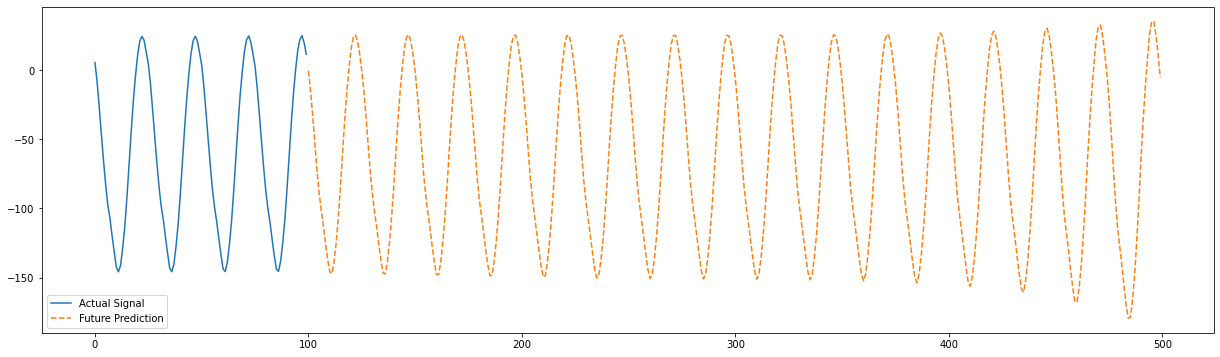

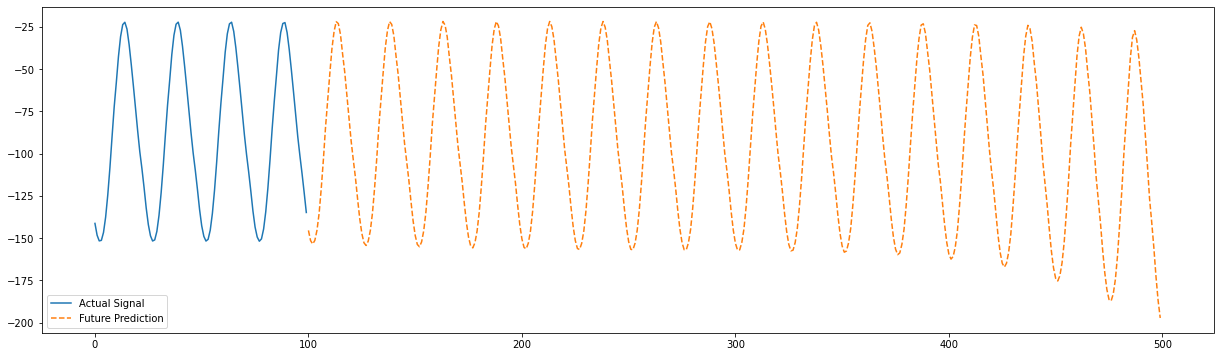

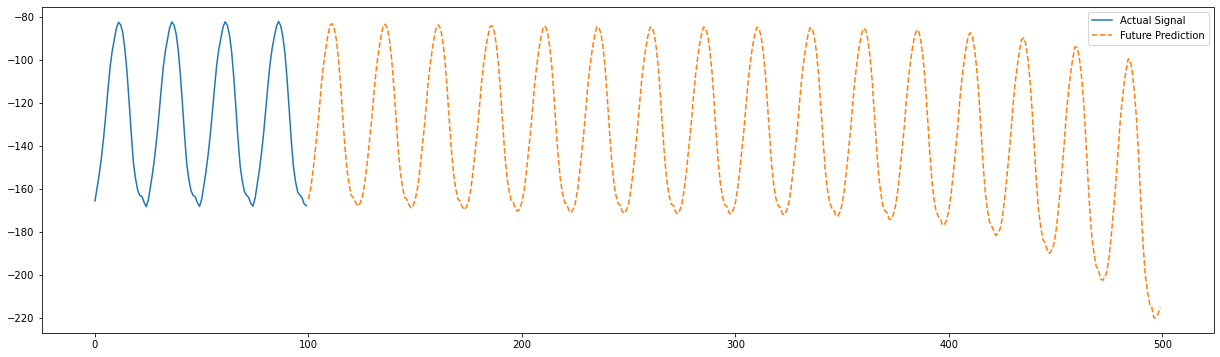

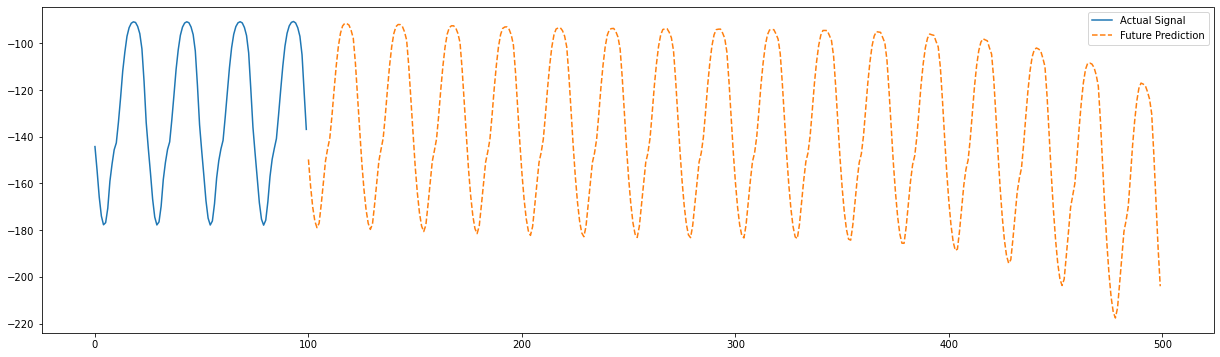

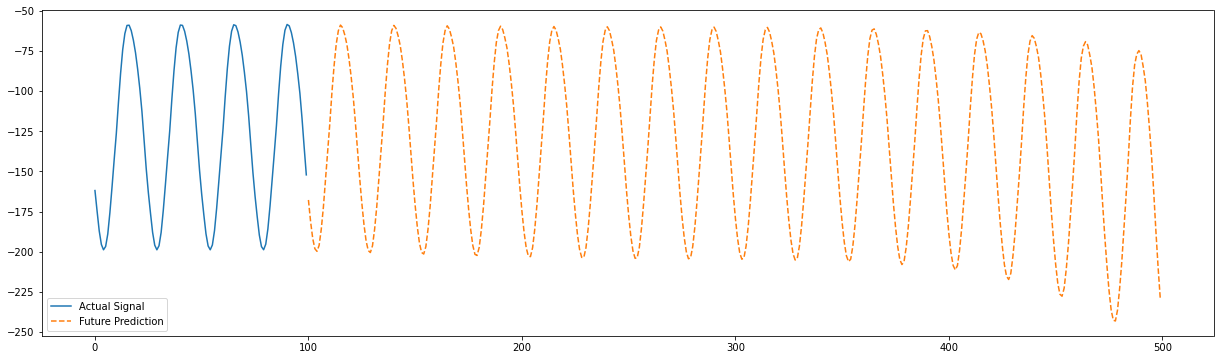

In [112]:
#Train all codes together---LSTM bounch Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


units_LSTM=100
# Define the LSTM model
def build_lstm_model(timesteps, latent_dim):

    lstm_model=Sequential()
    lstm_model.add(LSTM(units_LSTM, activation='tanh',input_shape=(timesteps, latent_dim)))
    lstm_model.add(RepeatVector(timesteps))
    lstm_model.add(LSTM(units_LSTM, activation='tanh',return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(latent_dim)))
                     
    return lstm_model

timesteps = 1
latent_dim=encoding_dim
lstm_model = build_lstm_model(timesteps, latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')

#lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0), loss='mse')

# Print LSTM model summary
lstm_model.summary()

#Encode the input data
encoded_data=y
print(encoded_data.shape)

# Reshape for LSTM input
encoded_data = np.reshape(encoded_data, (encoded_data.shape[0], timesteps, encoding_dim))
lstm_inputs=encoded_data[:-1]
print("lstm_inputs shape:",lstm_inputs.shape)
lstm_targets=encoded_data[1:]
print("lstm_targets shape:",lstm_inputs.shape)


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
									factor=0.5,
									patience=10,
									verbose=1,
									mode='min',
									min_delta=1e-10,
									cooldown=0,
									min_lr=0)
# Train the LSTM model
start_time = timeit.default_timer()
lstm_model.fit(lstm_inputs, lstm_targets, epochs=500, batch_size=32,validation_split=0.1,callbacks=[reduce_lr])
print("time spend for training:",timeit.default_timer() - start_time)

lstm_model.save('./Temp_data_Case2/model_bunch_'+str(encoding_dim)+'.h5')

lstm_model = load_model('./Temp_data_Case2/model_bunch_'+str(encoding_dim)+'.h5')

## Reshape for LSTM input
encoded_data = np.reshape(encoded_data, (encoded_data.shape[0], timesteps, latent_dim))

# Predict future states using the LSTM model

predicted_latent = lstm_model.predict(encoded_data[:-1])
print(predicted_latent.shape)

# Decode the predictions to get the original space
decoded_predictions = ae.decoder.predict(np.reshape(predicted_latent, (predicted_latent.shape[0], latent_dim)))

print(decoded_predictions.shape)

# decoded_predictions now contains the future states of your fluid dynamics data
print(two_dimension_data_0[1501,1000:1020])
print(decoded_predictions[1500,1000:1020])

# Extrapolation Function: Predict future timesteps beyond the training sequence
def extrapolate_lstm(lstm_model, encoded_data, future_steps):
    future_latent = []
    current_input = encoded_data
    
    for _ in range(future_steps):
        # Predict the next latent space
        next_latent = lstm_model.predict(current_input)

        future_latent.append(next_latent)
 
        current_input=next_latent
        
    future_latent=np.concatenate(future_latent,axis=1)
    return np.array(future_latent).squeeze()

# Number of future steps to predict
future_steps = 400

#print(encoded_data.shape)

# Perform extrapolation
start_time = timeit.default_timer()
future_latent_predictions = extrapolate_lstm(lstm_model, encoded_data[-1].reshape(1,1,latent_dim),future_steps)
print(encoded_data[-1].shape)
future_latent_predictions=np.array(future_latent_predictions)
print("time spend for prediction:",timeit.default_timer() - start_time)

pickle.dump(future_latent_predictions, open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "wb"))

# Decode the future latent predictions to the original space
decoded_future_predictions = [ae.decoder.predict(latent.reshape(1, -1)) for latent in future_latent_predictions]
print(np.array(decoded_future_predictions).shape)

# Combine the original and future predictions for the complete sequence
combined_predictions = np.concatenate([decoded_predictions, np.array(decoded_future_predictions).squeeze()])
print(np.array(decoded_future_predictions).squeeze().shape)
x_lstm=np.array(decoded_future_predictions).squeeze()
pickle.dump(x_lstm, open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(encoding_dim)+".pkl", "wb"))

# combined_predictions now contains the original and extrapolated future states of your fluid dynamics data
print(x_lstm[70,1000:1020])
print(training_data_whole.shape)
print(training_data_whole.reshape(training_data_whole.shape[0],110536)[1671,1000:1020])

print(x_lstm[300,1000:1020])
print(training_data_whole.reshape(training_data_whole.shape[0],110536)[1901,1000:1020])

print(x_lstm[399,1000:1020])
print(training_data_whole.reshape(training_data_whole.shape[0],110536)[2000,1000:1020])

print(encoded_data.shape)
encoded_data_2=np.transpose(encoded_data.squeeze())
print(encoded_data_2.shape)

future_latent_predictions_2=np.transpose(future_latent_predictions)
print(future_latent_predictions_2.shape)

for idx in range(encoded_data_2.shape[0]):
    plt.figure(figsize=(21, 6))
    plt.plot(encoded_data_2[idx, -100:], label='Actual Signal')
    plt.plot(np.arange(100, 100+ future_steps), future_latent_predictions_2[idx], label='Future Prediction', linestyle='dashed')
    plt.legend()
    plt.show()
    
    

(1601, 7)
(7, 1601)
training_data shape: (1601, 1)
(1531, 70, 1)
(1531, 1)
Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_326 (LSTM)              (None, 70, 50)            10400     
_________________________________________________________________
lstm_327 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
the 0 signal
Epoch 1/500
39/39 [==============================] - 2s 28ms/step - loss: 0.1284 - val_loss: 0.0890
Epoch 2/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0318 - val_loss: 0.0028
Epoch 3/500
39/39 [==============================] - 1s 21ms/step - loss: 0.0040 - val_los

39/39 [==============================] - 1s 22ms/step - loss: 1.7089e-04 - val_loss: 1.5662e-04
Epoch 69/500
39/39 [==============================] - 1s 21ms/step - loss: 1.5094e-04 - val_loss: 4.2789e-05

Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 70/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2547e-04 - val_loss: 3.4424e-05
Epoch 71/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2438e-04 - val_loss: 4.8117e-05
Epoch 72/500
39/39 [==============================] - 1s 21ms/step - loss: 1.1946e-04 - val_loss: 3.0605e-05
Epoch 73/500
39/39 [==============================] - 1s 20ms/step - loss: 1.1762e-04 - val_loss: 3.7102e-05
Epoch 74/500
39/39 [==============================] - 1s 21ms/step - loss: 1.1357e-04 - val_loss: 3.2120e-05
Epoch 75/500
39/39 [==============================] - 1s 21ms/step - loss: 1.1310e-04 - val_loss: 3.3551e-05
Epoch 76/500
39/39 [==============================] - 1s 20m

39/39 [==============================] - 1s 22ms/step - loss: 8.2397e-05 - val_loss: 2.7924e-05
Epoch 208/500
39/39 [==============================] - 1s 21ms/step - loss: 8.2400e-05 - val_loss: 2.7945e-05
Epoch 209/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2393e-05 - val_loss: 2.7931e-05

Epoch 00209: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 210/500
39/39 [==============================] - 1s 22ms/step - loss: 8.2392e-05 - val_loss: 2.7934e-05
Epoch 211/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2396e-05 - val_loss: 2.7933e-05
Epoch 212/500
39/39 [==============================] - 1s 21ms/step - loss: 8.2394e-05 - val_loss: 2.7943e-05
Epoch 213/500
39/39 [==============================] - 1s 21ms/step - loss: 8.2398e-05 - val_loss: 2.7934e-05
Epoch 214/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2392e-05 - val_loss: 2.7942e-05
Epoch 215/500
39/39 [==============================] 

39/39 [==============================] - 1s 22ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 346/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 347/500
39/39 [==============================] - 1s 24ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 348/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 349/500
39/39 [==============================] - 1s 19ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05

Epoch 00349: ReduceLROnPlateau reducing learning rate to 1.8626452377018543e-12.
Epoch 350/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 351/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 352/500
39/39 [==============================] - 1s 21ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 353/500
39/39 [==============================]

39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 484/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 485/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 486/500
39/39 [==============================] - 1s 22ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 487/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 488/500
39/39 [==============================] - 1s 23ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 489/500
39/39 [==============================] - 1s 19ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05

Epoch 00489: ReduceLROnPlateau reducing learning rate to 1.1368684312145107e-16.
Epoch 490/500
39/39 [==============================] - 1s 20ms/step - loss: 8.2384e-05 - val_loss: 2.7943e-05
Epoch 491/500
39/39 [==============================]

39/39 [==============================] - 1s 22ms/step - loss: 7.7022e-05 - val_loss: 2.6520e-05
Epoch 122/500
39/39 [==============================] - 1s 24ms/step - loss: 7.6615e-05 - val_loss: 3.1664e-05
Epoch 123/500
39/39 [==============================] - 1s 19ms/step - loss: 7.5770e-05 - val_loss: 2.8034e-05
Epoch 124/500
39/39 [==============================] - 1s 21ms/step - loss: 7.6357e-05 - val_loss: 3.6430e-05
Epoch 125/500
39/39 [==============================] - 1s 19ms/step - loss: 7.7533e-05 - val_loss: 2.8873e-05
Epoch 126/500
39/39 [==============================] - 1s 21ms/step - loss: 7.7135e-05 - val_loss: 2.8335e-05
Epoch 127/500
39/39 [==============================] - 1s 21ms/step - loss: 7.4406e-05 - val_loss: 2.7990e-05
Epoch 128/500
39/39 [==============================] - 1s 22ms/step - loss: 7.4489e-05 - val_loss: 2.9029e-05
Epoch 129/500
39/39 [==============================] - 1s 19ms/step - loss: 7.2880e-05 - val_loss: 2.5980e-05
Epoch 130/500
39/39 [===

39/39 [==============================] - 1s 22ms/step - loss: 6.3767e-05 - val_loss: 2.1433e-05
Epoch 195/500
39/39 [==============================] - 1s 19ms/step - loss: 6.4187e-05 - val_loss: 2.2578e-05
Epoch 196/500
39/39 [==============================] - 1s 19ms/step - loss: 6.3832e-05 - val_loss: 2.1784e-05
Epoch 197/500
39/39 [==============================] - 1s 21ms/step - loss: 6.3727e-05 - val_loss: 2.0880e-05
Epoch 198/500
39/39 [==============================] - 1s 23ms/step - loss: 6.3797e-05 - val_loss: 2.1205e-05
Epoch 199/500
39/39 [==============================] - 1s 19ms/step - loss: 6.4688e-05 - val_loss: 2.0710e-05
Epoch 200/500
39/39 [==============================] - 1s 19ms/step - loss: 6.3362e-05 - val_loss: 2.1540e-05
Epoch 201/500
39/39 [==============================] - 1s 22ms/step - loss: 6.3559e-05 - val_loss: 2.1795e-05
Epoch 202/500
39/39 [==============================] - 1s 22ms/step - loss: 6.3207e-05 - val_loss: 1.9974e-05
Epoch 203/500
39/39 [===

Epoch 265/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9863e-05 - val_loss: 1.8938e-05
Epoch 266/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9855e-05 - val_loss: 1.8999e-05
Epoch 267/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9869e-05 - val_loss: 1.8970e-05
Epoch 268/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9903e-05 - val_loss: 1.9009e-05
Epoch 269/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9864e-05 - val_loss: 1.9015e-05
Epoch 270/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9855e-05 - val_loss: 1.9009e-05
Epoch 271/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9860e-05 - val_loss: 1.8997e-05
Epoch 272/500
39/39 [==============================] - 1s 19ms/step - loss: 5.9861e-05 - val_loss: 1.8985e-05
Epoch 273/500
39/39 [==============================] - 1s 19ms/step - loss: 5.9843e-05 - val_loss: 1.8970e-05

Epoch 002

39/39 [==============================] - 1s 19ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 405/500
39/39 [==============================] - 1s 24ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 406/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 407/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 408/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 409/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 410/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 411/500
39/39 [==============================] - 1s 23ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 412/500
39/39 [==============================] - 1s 22ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 413/500
39/39 [===

39/39 [==============================] - 1s 23ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 475/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 476/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 477/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 478/500
39/39 [==============================] - 1s 23ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 479/500
39/39 [==============================] - 1s 21ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 480/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 481/500
39/39 [==============================] - 1s 20ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 482/500
39/39 [==============================] - 1s 22ms/step - loss: 5.9774e-05 - val_loss: 1.8999e-05
Epoch 483/500
39/39 [===

Epoch 39/500
39/39 [==============================] - 1s 22ms/step - loss: 2.4023e-04 - val_loss: 8.7399e-05
Epoch 40/500
39/39 [==============================] - 1s 20ms/step - loss: 2.4826e-04 - val_loss: 8.8723e-05
Epoch 41/500
39/39 [==============================] - 1s 21ms/step - loss: 2.5592e-04 - val_loss: 1.5575e-04
Epoch 42/500
39/39 [==============================] - 1s 24ms/step - loss: 2.3718e-04 - val_loss: 1.4726e-04
Epoch 43/500
39/39 [==============================] - 1s 21ms/step - loss: 2.3879e-04 - val_loss: 8.9776e-05
Epoch 44/500
39/39 [==============================] - 1s 22ms/step - loss: 2.2566e-04 - val_loss: 1.3712e-04
Epoch 45/500
39/39 [==============================] - 1s 22ms/step - loss: 2.2283e-04 - val_loss: 7.9765e-05
Epoch 46/500
39/39 [==============================] - 1s 21ms/step - loss: 2.1154e-04 - val_loss: 8.5858e-05
Epoch 47/500
39/39 [==============================] - 1s 20ms/step - loss: 2.1662e-04 - val_loss: 1.1756e-04
Epoch 48/500
39/39 

39/39 [==============================] - 1s 23ms/step - loss: 1.0042e-04 - val_loss: 2.3455e-05
Epoch 184/500
39/39 [==============================] - 1s 20ms/step - loss: 9.9959e-05 - val_loss: 2.2868e-05
Epoch 185/500
39/39 [==============================] - 1s 20ms/step - loss: 9.9558e-05 - val_loss: 2.3645e-05
Epoch 186/500
39/39 [==============================] - 1s 22ms/step - loss: 9.9347e-05 - val_loss: 2.3578e-05
Epoch 187/500
39/39 [==============================] - 1s 21ms/step - loss: 9.9763e-05 - val_loss: 2.4272e-05
Epoch 188/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0024e-04 - val_loss: 2.3804e-05
Epoch 189/500
39/39 [==============================] - 1s 19ms/step - loss: 9.9711e-05 - val_loss: 2.2770e-05
Epoch 190/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0035e-04 - val_loss: 2.3608e-05
Epoch 191/500
39/39 [==============================] - 1s 22ms/step - loss: 9.9364e-05 - val_loss: 2.5074e-05
Epoch 192/500
39/39 [===

39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 324/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 325/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 326/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 327/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 328/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 329/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 330/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 331/500
39/39 [==============================] - 1s 19ms/step - loss: 9.6795e-05 - val_loss: 2.2641e-05
Epoch 332/500
39/39 [===

39/39 [==============================] - 1s 24ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 394/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 395/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 396/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 397/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 398/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 399/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 400/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 401/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 402/500
39/39 [===

39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 464/500
39/39 [==============================] - 1s 19ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 465/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 466/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 467/500
39/39 [==============================] - 1s 22ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 468/500
39/39 [==============================] - 1s 22ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 469/500
39/39 [==============================] - 1s 20ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 470/500
39/39 [==============================] - 1s 23ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 471/500
39/39 [==============================] - 1s 21ms/step - loss: 9.6795e-05 - val_loss: 2.2642e-05
Epoch 472/500
39/39 [===

Epoch 28/500
39/39 [==============================] - 1s 19ms/step - loss: 2.6891e-04 - val_loss: 1.4378e-04
Epoch 29/500
39/39 [==============================] - 1s 19ms/step - loss: 2.8007e-04 - val_loss: 1.1482e-04
Epoch 30/500
39/39 [==============================] - 1s 19ms/step - loss: 2.8437e-04 - val_loss: 9.2171e-05
Epoch 31/500
39/39 [==============================] - 1s 19ms/step - loss: 3.0690e-04 - val_loss: 1.2992e-04
Epoch 32/500
39/39 [==============================] - 1s 22ms/step - loss: 2.6324e-04 - val_loss: 7.3448e-05

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 33/500
39/39 [==============================] - 1s 20ms/step - loss: 2.1686e-04 - val_loss: 1.0669e-04
Epoch 34/500
39/39 [==============================] - 1s 20ms/step - loss: 2.1542e-04 - val_loss: 5.8907e-05
Epoch 35/500
39/39 [==============================] - 1s 20ms/step - loss: 2.1255e-04 - val_loss: 2.5210e-04
Epoch 36/500
39/39 [===========================

39/39 [==============================] - 1s 21ms/step - loss: 1.2269e-04 - val_loss: 2.3890e-05
Epoch 172/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2341e-04 - val_loss: 2.4007e-05
Epoch 173/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2301e-04 - val_loss: 2.4025e-05

Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 174/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2323e-04 - val_loss: 2.4220e-05
Epoch 175/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2261e-04 - val_loss: 2.3897e-05
Epoch 176/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2250e-04 - val_loss: 2.4123e-05
Epoch 177/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2269e-04 - val_loss: 2.3992e-05
Epoch 178/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2263e-04 - val_loss: 2.4255e-05
Epoch 179/500
39/39 [==============================]

39/39 [==============================] - 1s 22ms/step - loss: 1.2160e-04 - val_loss: 2.3817e-05
Epoch 314/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3817e-05
Epoch 315/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2160e-04 - val_loss: 2.3817e-05
Epoch 316/500
39/39 [==============================] - 1s 23ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 317/500
39/39 [==============================] - 1s 23ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 318/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3817e-05
Epoch 319/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2160e-04 - val_loss: 2.3817e-05
Epoch 320/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 321/500
39/39 [==============================] - 1s 24ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 322/500
39/39 [===

39/39 [==============================] - 1s 19ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 384/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 385/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 386/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 387/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 388/500
39/39 [==============================] - 1s 24ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 389/500
39/39 [==============================] - 1s 19ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 390/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 391/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 392/500
39/39 [===

39/39 [==============================] - 1s 19ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 454/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 455/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 456/500
39/39 [==============================] - 1s 21ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 457/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 458/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 459/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 460/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 461/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2160e-04 - val_loss: 2.3816e-05
Epoch 462/500
39/39 [===

Epoch 17/500
39/39 [==============================] - 1s 19ms/step - loss: 3.1307e-04 - val_loss: 1.4557e-04
Epoch 18/500
39/39 [==============================] - 1s 20ms/step - loss: 2.9974e-04 - val_loss: 1.4530e-04
Epoch 19/500
39/39 [==============================] - 1s 20ms/step - loss: 2.9775e-04 - val_loss: 1.3802e-04
Epoch 20/500
39/39 [==============================] - 1s 20ms/step - loss: 2.8799e-04 - val_loss: 1.2249e-04
Epoch 21/500
39/39 [==============================] - 1s 20ms/step - loss: 2.9817e-04 - val_loss: 1.5986e-04
Epoch 22/500
39/39 [==============================] - 1s 20ms/step - loss: 3.2332e-04 - val_loss: 1.6221e-04
Epoch 23/500
39/39 [==============================] - 1s 22ms/step - loss: 2.8259e-04 - val_loss: 2.0489e-04
Epoch 24/500
39/39 [==============================] - 1s 20ms/step - loss: 3.5058e-04 - val_loss: 1.5741e-04
Epoch 25/500
39/39 [==============================] - 1s 20ms/step - loss: 2.8411e-04 - val_loss: 1.3279e-04
Epoch 26/500
39/39 

39/39 [==============================] - 1s 20ms/step - loss: 6.5458e-05 - val_loss: 2.2221e-05
Epoch 162/500
39/39 [==============================] - 1s 21ms/step - loss: 6.5568e-05 - val_loss: 2.1984e-05
Epoch 163/500
39/39 [==============================] - 1s 22ms/step - loss: 6.5565e-05 - val_loss: 2.2426e-05
Epoch 164/500
39/39 [==============================] - 1s 19ms/step - loss: 6.5434e-05 - val_loss: 2.2052e-05

Epoch 00164: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 165/500
39/39 [==============================] - 1s 20ms/step - loss: 6.5210e-05 - val_loss: 2.2115e-05
Epoch 166/500
39/39 [==============================] - 1s 21ms/step - loss: 6.5227e-05 - val_loss: 2.2334e-05
Epoch 167/500
39/39 [==============================] - 1s 20ms/step - loss: 6.5182e-05 - val_loss: 2.1991e-05
Epoch 168/500
39/39 [==============================] - 1s 23ms/step - loss: 6.5164e-05 - val_loss: 2.1599e-05
Epoch 169/500
39/39 [==============================] 

39/39 [==============================] - 1s 19ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 300/500
39/39 [==============================] - 1s 19ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 301/500
39/39 [==============================] - 1s 24ms/step - loss: 6.4764e-05 - val_loss: 2.1800e-05
Epoch 302/500
39/39 [==============================] - 1s 22ms/step - loss: 6.4764e-05 - val_loss: 2.1800e-05
Epoch 303/500
39/39 [==============================] - 1s 22ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 304/500
39/39 [==============================] - 1s 21ms/step - loss: 6.4764e-05 - val_loss: 2.1800e-05

Epoch 00304: ReduceLROnPlateau reducing learning rate to 2.3841859042583735e-10.
Epoch 305/500
39/39 [==============================] - 1s 21ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 306/500
39/39 [==============================] - 1s 19ms/step - loss: 6.4764e-05 - val_loss: 2.1800e-05
Epoch 307/500
39/39 [==============================]

39/39 [==============================] - 1s 21ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 438/500
39/39 [==============================] - 1s 23ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 439/500
39/39 [==============================] - 1s 22ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 440/500
39/39 [==============================] - 1s 20ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 441/500
39/39 [==============================] - 1s 19ms/step - loss: 6.4764e-05 - val_loss: 2.1800e-05
Epoch 442/500
39/39 [==============================] - 1s 20ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 443/500
39/39 [==============================] - 1s 22ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05
Epoch 444/500
39/39 [==============================] - 1s 20ms/step - loss: 6.4763e-05 - val_loss: 2.1800e-05

Epoch 00444: ReduceLROnPlateau reducing learning rate to 1.4551915919545737e-14.
Epoch 445/500
39/39 [==============================]

39/39 [==============================] - 2s 29ms/step - loss: 0.0637 - val_loss: 0.0273
Epoch 2/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0245 - val_loss: 0.0227
Epoch 3/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0192 - val_loss: 0.0092
Epoch 4/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0044 - val_loss: 9.6835e-04
Epoch 5/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0023 - val_loss: 7.0654e-04
Epoch 6/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0018 - val_loss: 8.1387e-04
Epoch 7/500
39/39 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/500
39/39 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 3.9770e-04
Epoch 9/500
39/39 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 3.7011e-04
Epoch 10/500
39/39 [==============================] - 1s 21ms/step - loss: 9.3774e-04 - val_

39/39 [==============================] - 1s 22ms/step - loss: 1.2280e-04 - val_loss: 3.7839e-05
Epoch 149/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2413e-04 - val_loss: 4.6939e-05
Epoch 150/500
39/39 [==============================] - 1s 19ms/step - loss: 1.2422e-04 - val_loss: 3.6434e-05
Epoch 151/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2150e-04 - val_loss: 4.8311e-05
Epoch 152/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2009e-04 - val_loss: 3.5527e-05
Epoch 153/500
39/39 [==============================] - 1s 19ms/step - loss: 1.2253e-04 - val_loss: 7.1569e-05
Epoch 154/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2259e-04 - val_loss: 4.6402e-05
Epoch 155/500
39/39 [==============================] - 1s 22ms/step - loss: 1.2444e-04 - val_loss: 5.3004e-05
Epoch 156/500
39/39 [==============================] - 1s 20ms/step - loss: 1.2478e-04 - val_loss: 3.3346e-05
Epoch 157/500
39/39 [===


Epoch 00289: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 290/500
39/39 [==============================] - 1s 21ms/step - loss: 1.0256e-04 - val_loss: 3.1357e-05
Epoch 291/500
39/39 [==============================] - 1s 21ms/step - loss: 1.0255e-04 - val_loss: 3.1366e-05
Epoch 292/500
39/39 [==============================] - 1s 23ms/step - loss: 1.0256e-04 - val_loss: 3.1368e-05
Epoch 293/500
39/39 [==============================] - 1s 21ms/step - loss: 1.0256e-04 - val_loss: 3.1370e-05
Epoch 294/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0256e-04 - val_loss: 3.1359e-05
Epoch 295/500
39/39 [==============================] - 1s 21ms/step - loss: 1.0256e-04 - val_loss: 3.1381e-05
Epoch 296/500
39/39 [==============================] - 1s 19ms/step - loss: 1.0255e-04 - val_loss: 3.1358e-05
Epoch 297/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0256e-04 - val_loss: 3.1364e-05
Epoch 298/500
39/39 [==================

39/39 [==============================] - 1s 22ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 429/500
39/39 [==============================] - 1s 19ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05

Epoch 00429: ReduceLROnPlateau reducing learning rate to 3.725290475403709e-12.
Epoch 430/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 431/500
39/39 [==============================] - 1s 22ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 432/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 433/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 434/500
39/39 [==============================] - 1s 19ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 435/500
39/39 [==============================] - 1s 20ms/step - loss: 1.0253e-04 - val_loss: 3.1367e-05
Epoch 436/500
39/39 [==============================] 

39/39 [==============================] - 1s 22ms/step - loss: 3.0598e-04 - val_loss: 5.6475e-05
Epoch 62/500
39/39 [==============================] - 1s 21ms/step - loss: 2.9218e-04 - val_loss: 7.0950e-05
Epoch 63/500
39/39 [==============================] - 1s 20ms/step - loss: 2.9555e-04 - val_loss: 9.5256e-05
Epoch 64/500
39/39 [==============================] - 1s 20ms/step - loss: 2.9155e-04 - val_loss: 5.2260e-05
Epoch 65/500
39/39 [==============================] - 1s 21ms/step - loss: 2.8715e-04 - val_loss: 1.0803e-04
Epoch 66/500
39/39 [==============================] - 1s 22ms/step - loss: 2.9898e-04 - val_loss: 9.5482e-05

Epoch 00066: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 67/500
39/39 [==============================] - 1s 25ms/step - loss: 2.8685e-04 - val_loss: 5.2670e-05
Epoch 68/500
39/39 [==============================] - 1s 21ms/step - loss: 2.8056e-04 - val_loss: 5.2292e-05
Epoch 69/500
39/39 [==============================] - 1s 19ms

Epoch 131/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6682e-04 - val_loss: 5.2376e-05
Epoch 132/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6692e-04 - val_loss: 5.2332e-05
Epoch 133/500
39/39 [==============================] - 1s 19ms/step - loss: 2.6693e-04 - val_loss: 5.2489e-05
Epoch 134/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6701e-04 - val_loss: 5.2655e-05
Epoch 135/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6693e-04 - val_loss: 5.2311e-05
Epoch 136/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6686e-04 - val_loss: 5.2326e-05

Epoch 00136: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 137/500
39/39 [==============================] - 1s 22ms/step - loss: 2.6671e-04 - val_loss: 5.2558e-05
Epoch 138/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6671e-04 - val_loss: 5.2551e-05
Epoch 139/500
39/39 [==================

39/39 [==============================] - 1s 22ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 270/500
39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 271/500
39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 272/500
39/39 [==============================] - 1s 22ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 273/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 274/500
39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 275/500
39/39 [==============================] - 1s 19ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 276/500
39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05

Epoch 00276: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
Epoch 277/500
39/39 [==============================] 

39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 408/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 409/500
39/39 [==============================] - 1s 22ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 410/500
39/39 [==============================] - 1s 23ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 411/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 412/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 413/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 414/500
39/39 [==============================] - 1s 23ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 415/500
39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 416/500
39/39 [===

39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 478/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 479/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 480/500
39/39 [==============================] - 1s 22ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 481/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 482/500
39/39 [==============================] - 1s 20ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 483/500
39/39 [==============================] - 1s 21ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 484/500
39/39 [==============================] - 1s 22ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 485/500
39/39 [==============================] - 1s 23ms/step - loss: 2.6647e-04 - val_loss: 5.2420e-05
Epoch 486/500
39/39 [===

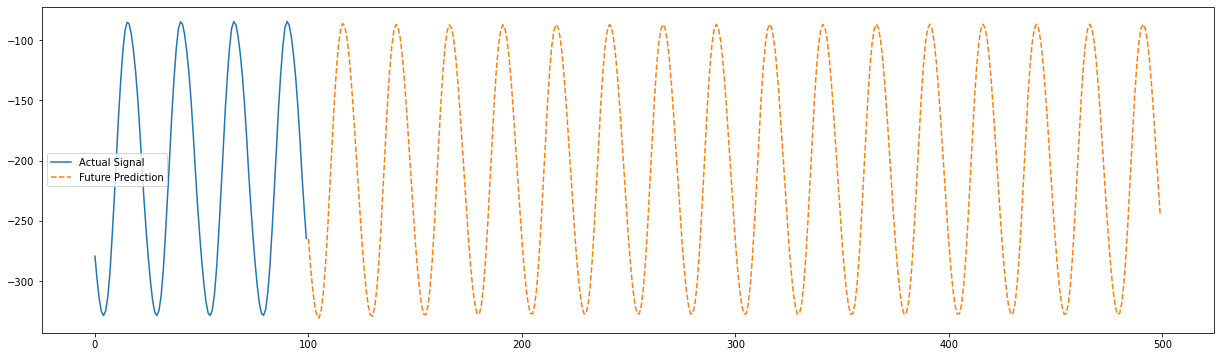

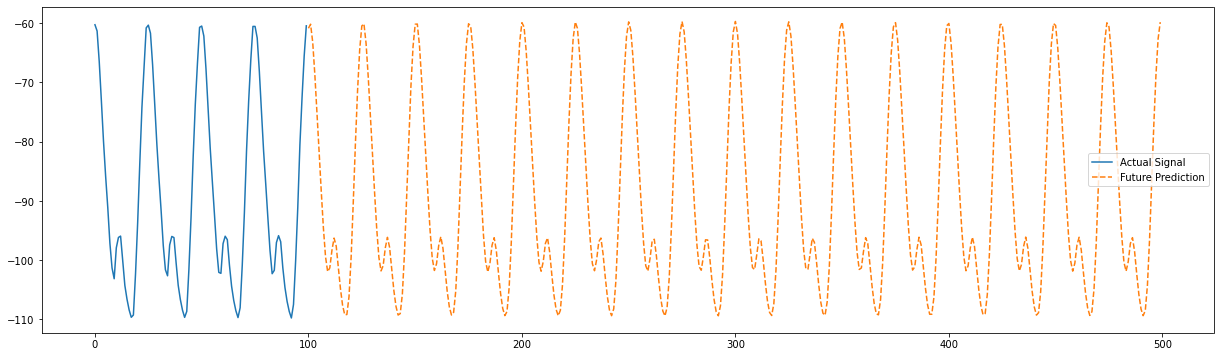

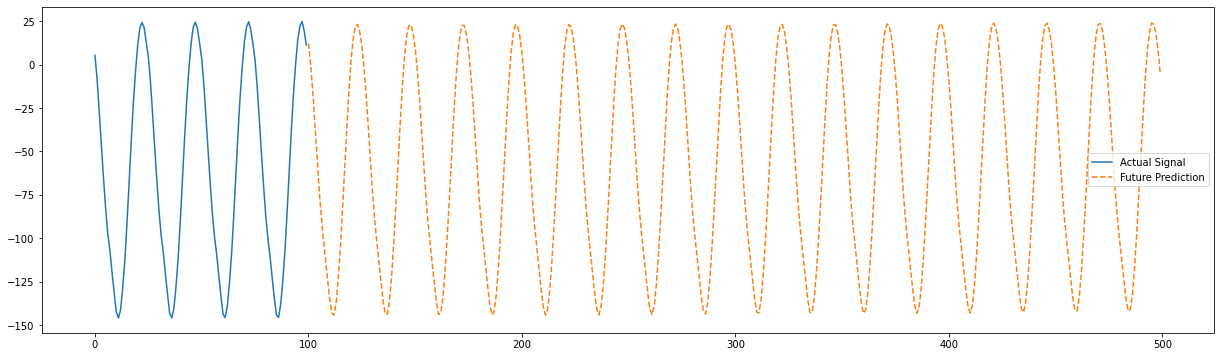

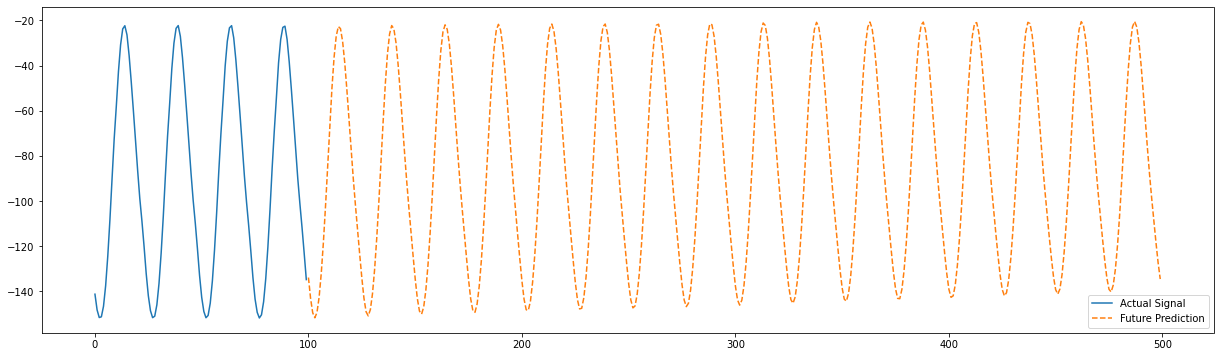

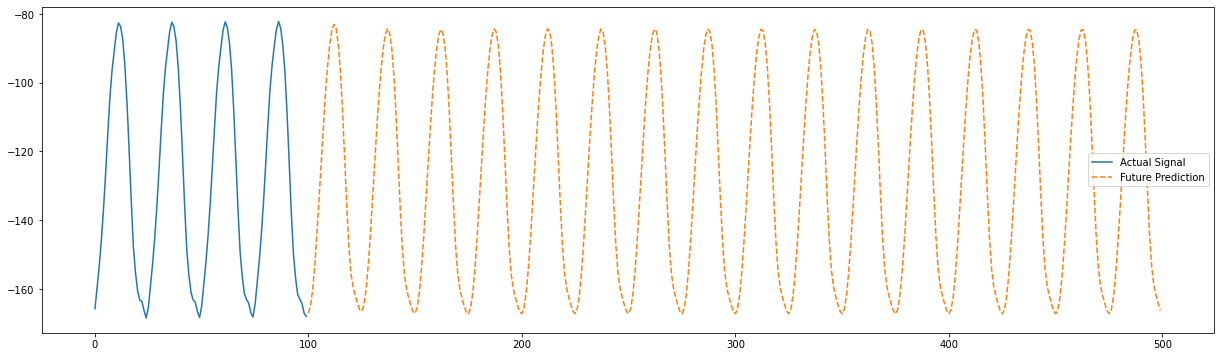

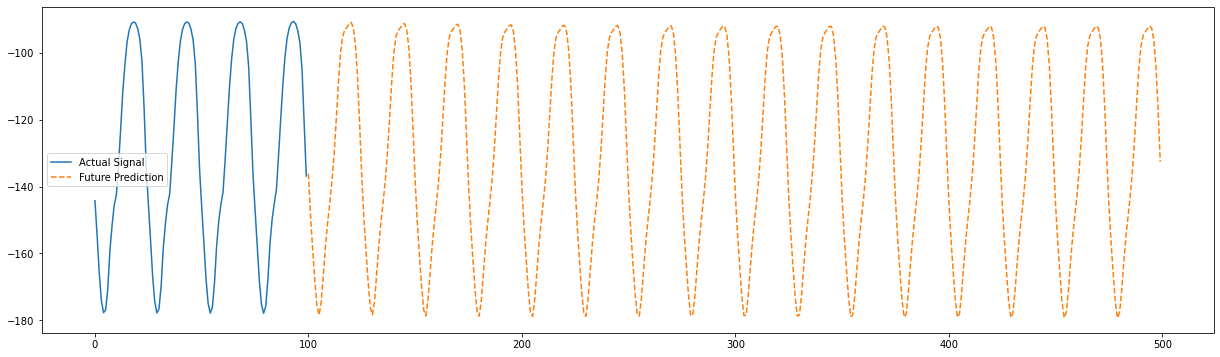

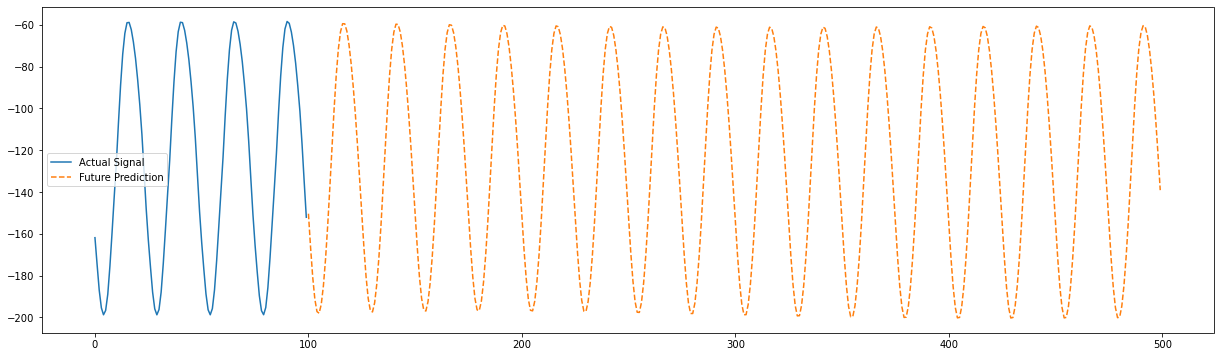

In [113]:
#Train each code using a single LSTM model---LSTM-individual Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

units_LSTM=100

print(y.shape)
# Generate a sample dataset (replace with your actual data)
data=np.array(np.transpose(y))
print(data.shape)

# Define the sequence length for LSTM
seq_length_collection = [10,20,30,40,50,60,70,80]
future_steps = pred_time_steps  # Number of future steps to predict

for seq_length in seq_length_collection:
    # Placeholder for reconstructed signals
    reconstructed_signals = []
    future_predictions_lstm = []

    # Loop over each signal
    for idx in range(data.shape[0]):
        start_time = timeit.default_timer()
        
        training_data = data[idx].reshape(data.shape[1],1)
        print('training_data shape:',training_data.shape)
    
        # Normalize the data
        scaler = MinMaxScaler()
        training_data_scaled = scaler.fit_transform(training_data)
    
        # Split the data into train and test sets
        #train_size = int(len(training_data_scaled) * 0.9)
        #train, test = training_data_scaled[:train_size], training_data_scaled[train_size:]
    
        # Prepare the input and output sequences for LSTM
        def create_sequences(data, seq_length):
            xs, ys = [], []
            for i in range(len(data) - seq_length):
                x = data[i:i + seq_length]
                y = data[i + seq_length]
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)
    
        X_train, y_train = create_sequences(training_data_scaled, seq_length)
        print(X_train.shape)
        print(y_train.shape)
        #X_test, y_test = create_sequences(test, seq_length)
        #print(X_test.shape)
        #print(y_test.shape)
    
        # Build the LSTM model
        model = Sequential([
            LSTM(units_LSTM, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
            LSTM(units_LSTM),
            Dense(X_train.shape[2])
        ])
    
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        model.summary()

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')        
              
        
        print("the {0} signal".format(idx))
        # Train the model
        #model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)
        # Callbacks
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.5,
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            min_delta=1e-10,
                                            cooldown=0,
                                            min_lr=0)
        # Train the LSTM model
        model.fit(X_train, y_train,  epochs=500, batch_size=32,validation_split=0.1,callbacks=[reduce_lr])
        print("time spend for training:",timeit.default_timer() - start_time)
      
        # Make predictions
        start_time = timeit.default_timer()
        #predicted_signal_2 = model.predict(X_test)
        #print('predicted_signal_2 shape:',predicted_signal_2.shape)
    
        # Rescale the predicted IMFs
        #predicted_signal = scaler.inverse_transform(predicted_signal_2)
    
        # Store the reconstructed signal
        #reconstructed_signals.append(predicted_signal) 
    
        # Extrapolate future data
        #last_sequence = X_test[-1]
        last_sequence = X_train[-1]
        future_imfs = []
    
        for _ in range(future_steps):
            # Predict the next set of IMFs
            next_imf = model.predict(last_sequence[np.newaxis, :])
            future_imfs.append(next_imf[0])
        
            # Update last_sequence to include the newly predicted IMFs
            last_sequence = np.vstack([last_sequence[1:], next_imf])
    
        # Rescale and sum future IMFs to reconstruct future signal
        future_signal = scaler.inverse_transform(np.array(future_imfs))
        future_predictions_lstm.append(future_signal)
        print("time spend for prediction:",timeit.default_timer() - start_time)
    # Convert lists to numpy arrays
    #reconstructed_signals = np.array(reconstructed_signals)
    #pickle.dump(reconstructed_signals, open("./Temp_data_Case2/reconstructed_signals_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "wb"))

    future_predictions_lstm = np.array(future_predictions_lstm)
    pickle.dump(future_predictions_lstm, open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "wb"))

    print(future_predictions_lstm.shape)

    # Plot the actual and predicted signals for the first signal as an example
    #Replace len(reconstructed_signals[idx]) with integer 100
    for idx in range(data.shape[0]):
        plt.figure(figsize=(21, 6))
        plt.plot(data[idx, -100:], label='Actual Signal')
        #plt.plot(reconstructed_signals[idx], label='Predicted Signal', linestyle='dashed')
        plt.plot(np.arange(100, 100+ future_steps), future_predictions_lstm[idx], label='Future Prediction', linestyle='dashed')
        
        plt.legend()
        plt.show()
        

(7, 400, 1)
(7, 400)
(7, 1601)
(100,)
(400, 1)
(7, 400)


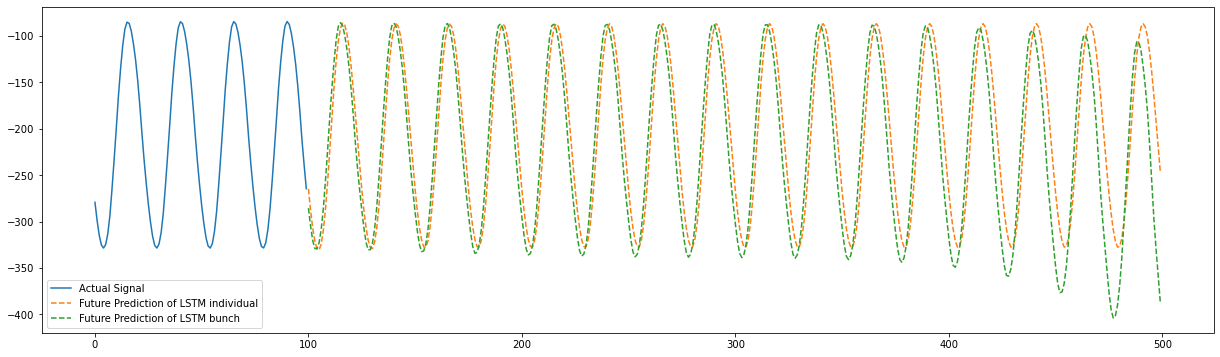

(100,)
(400, 1)
(7, 400)


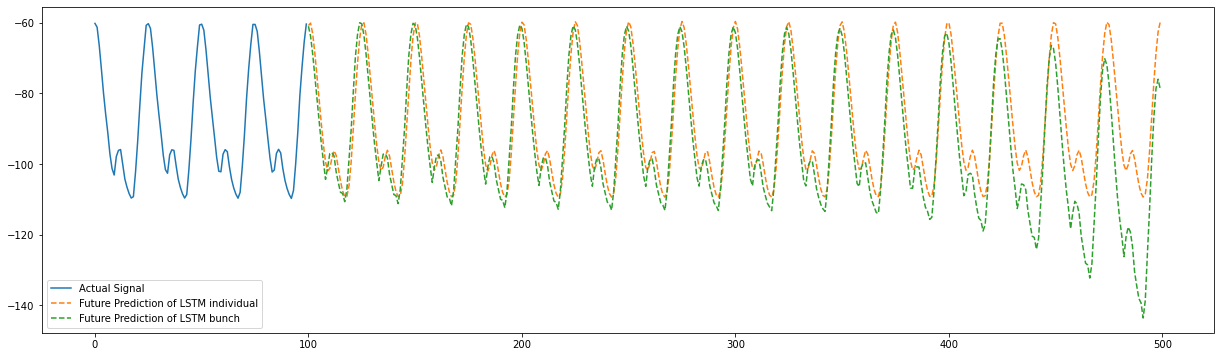

(100,)
(400, 1)
(7, 400)


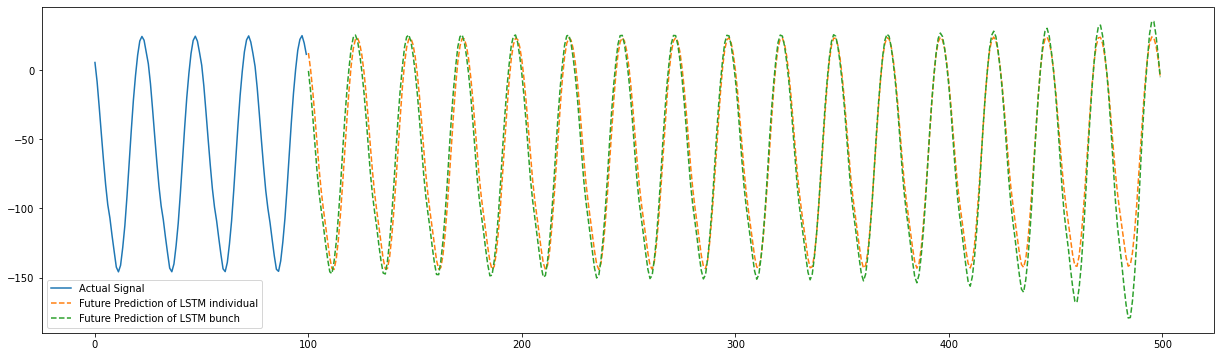

(100,)
(400, 1)
(7, 400)


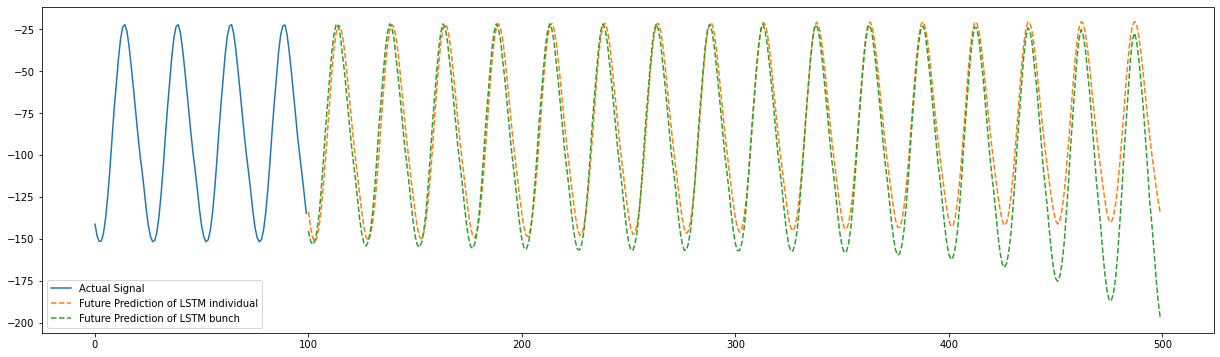

(100,)
(400, 1)
(7, 400)


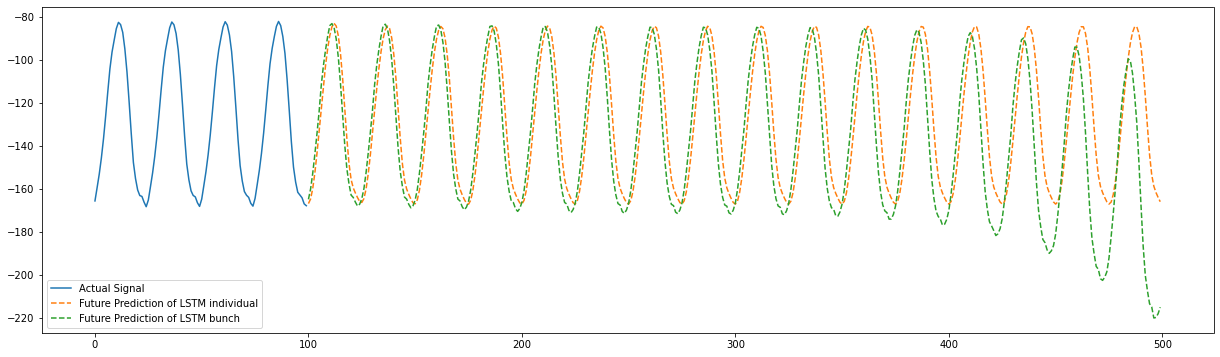

(100,)
(400, 1)
(7, 400)


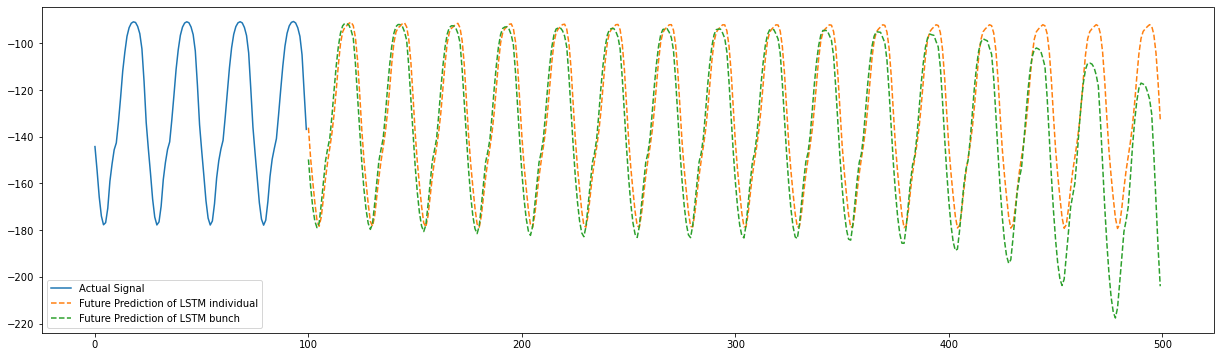

(100,)
(400, 1)
(7, 400)


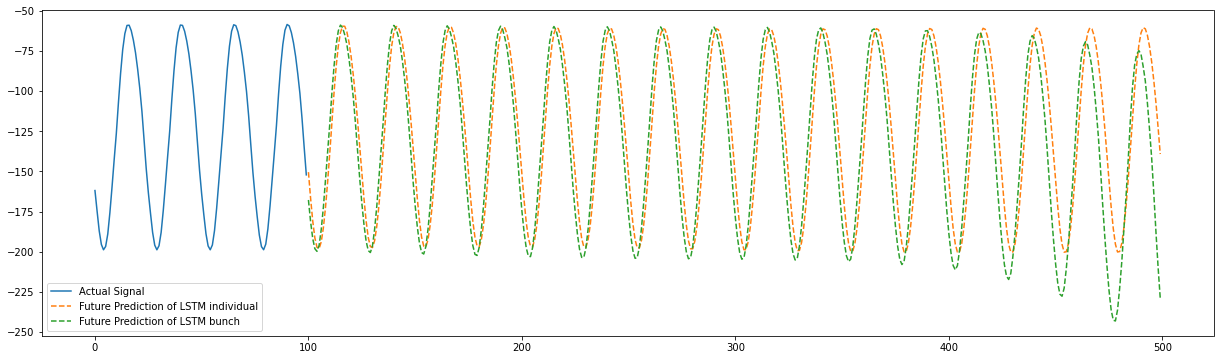

In [114]:
seq_length=70
#reconstructed_signals=joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "rb"))
future_predictions_lstm=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", "rb"))
print(future_predictions_lstm.shape)
future_latent_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "rb")))
print(future_latent_predictions_lstm_bunch.shape)

data=np.array(np.transpose(y))
print(data.shape)
# Plot the actual and predicted signals for the first signal as an example
#Replace len(reconstructed_signals[idx]) with integer 100
for idx in range(data.shape[0]):
    plt.figure(figsize=(21, 6))
    print(data[idx, -100:].shape)
    plt.plot(data[idx, -100:], label='Actual Signal')
    
    print(future_predictions_lstm[idx].shape)
    plt.plot(np.arange(100, 100 + future_steps), future_predictions_lstm[idx], label='Future Prediction of LSTM individual', linestyle='dashed')
    print(future_latent_predictions_lstm_bunch.shape)
    plt.plot(np.arange(100, 100 + future_steps), future_latent_predictions_lstm_bunch[idx], label='Future Prediction of LSTM bunch', linestyle='dashed')
    plt.legend()
    plt.show()

In [4]:
#Python code of Dynamic Mode Decomposition
class DMD(object):
  def y_plus(self,y_data):
    """ the encoded output data without the first time series state. """
    return y_data[:, 1:]

  def y_minus(self,y_data):
    """ the encoded output data without the last time series state. """
    return y_data[:, :-1]

  def get_amat(self,y_data,r):
    """ Compute DMD A matrix by the singular value decomposition. """
    X2 = self.y_plus(y_data)
    X1 = self.y_minus(y_data)
    # compute A using the pseudoinverse.
    # return y_plus2 @ tf.linalg.pinv(y_minus2)
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices=False)
    print("Singular value matrix's shape",s.shape)
    print("Singular value array",s)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    return A

  def get_predicted_y(self,y_data,r,pred_step):
    #data=np.array(y_data)[:,0:-pred_step]
    data = np.array(y_data)[:,:]
    N, T = data.shape
    A = self.get_amat(data, r)
    print(A.shape)
    print(A)
    mat2 = np.append(data, np.zeros((N, pred_step)), axis=1)
    #print(mat2.shape)
    for s in range(pred_step):
      mat2[:, T + s] =(A @ mat2[:, T + s - 1]).real#
    # return mat[:, - pred_step :]
    #print(mat2[:,pred_step:].shape)
    return mat2[:,pred_step:]

In [116]:
#The prediction result of SAE-DMD model in different code length
dmd=DMD()
# start timer.
start_time = timeit.default_timer()

print("y.shape",y.shape)
y_pred = dmd.get_predicted_y(tf.transpose(y),int(encoding_dim),future_steps)# rank equals 10 and estimate time step equals 10
print("y_pred_before_transpose",y_pred.shape)

print("time spend for prediction:",timeit.default_timer() - start_time)


y.shape (1601, 7)
Singular value matrix's shape (7,)
Singular value array [13509.78     2786.7446   2734.2444   1118.2303    566.8139    152.42242
    73.74122]
(7, 7)
[[ 0.8381967 -4.28849091e-07j -0.36448485-1.43451260e-07j
  -0.12290192+9.30094188e-08j -0.31404924+7.84747101e-07j
   0.5583892 +2.99239389e-09j -0.13611889+2.00817385e-06j
   0.37561226+2.20905349e-06j]
 [-0.05685568-2.18544926e-07j  1.088318  -1.17744825e-07j
  -0.46791387-2.96968409e-07j -0.6037756 -1.02603838e-06j
  -0.2938919 +1.07758360e-07j  0.71594524+1.17267871e-06j
   0.24433184+1.81360724e-06j]
 [ 0.02757901+7.09580839e-09j  0.22265129-7.69757449e-08j
   0.48470986+2.97877932e-07j -0.24856651+7.40011956e-07j
  -0.54208183-2.27898667e-07j  0.54486775+5.40456142e-07j
   0.2098651 +7.27887596e-07j]
 [-0.11697274-1.44847576e-07j -0.2494286 -6.53831549e-08j
  -0.04976892-2.21517482e-07j  0.65604746-5.47150421e-07j
   0.39543292-5.95374878e-08j -0.01094723+7.72085116e-07j
   0.24500108+1.12236751e-06j]
 [-0.0663517

Original code (7, 1601)
DMD predict (7, 1601)
(7, 400, 1)
LSTM predict (7, 400)
LSTM predict&original (7, 1601)
(7, 400)
(7, 1601)
LSTM predict_bunch&original (7, 1601)


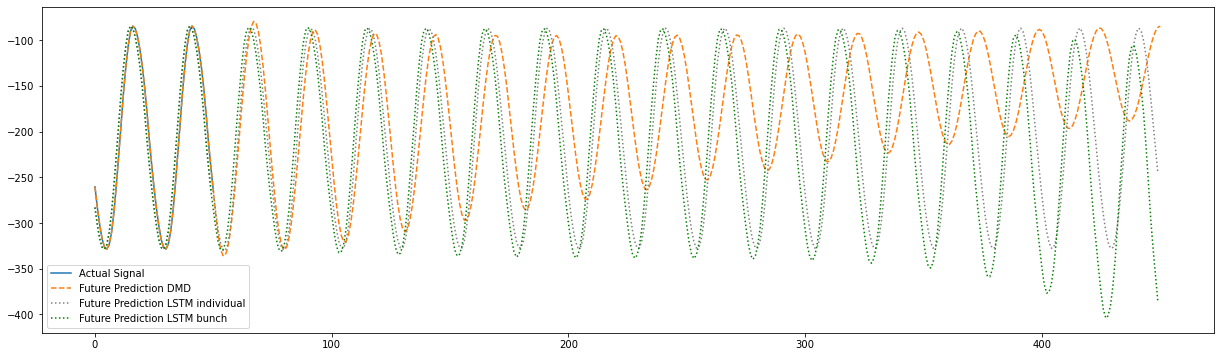

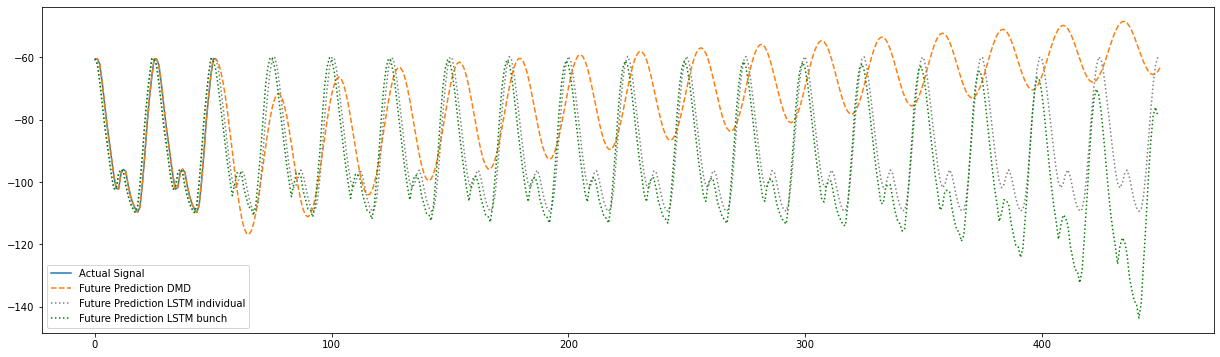

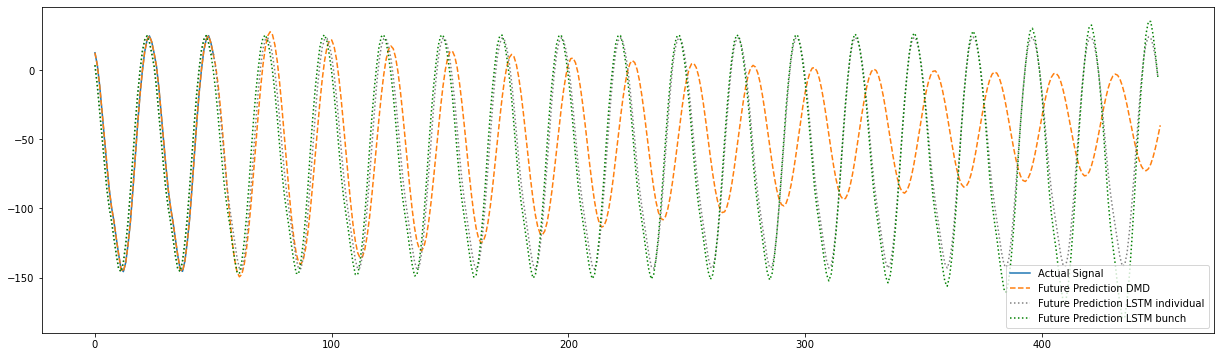

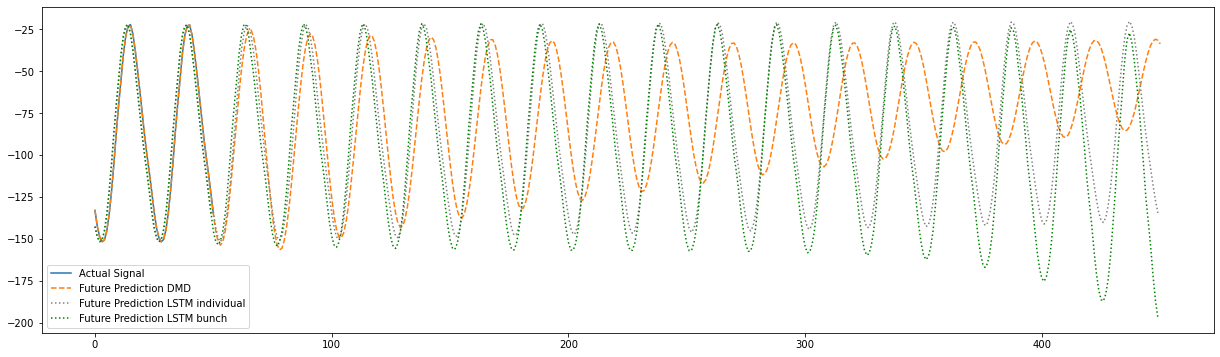

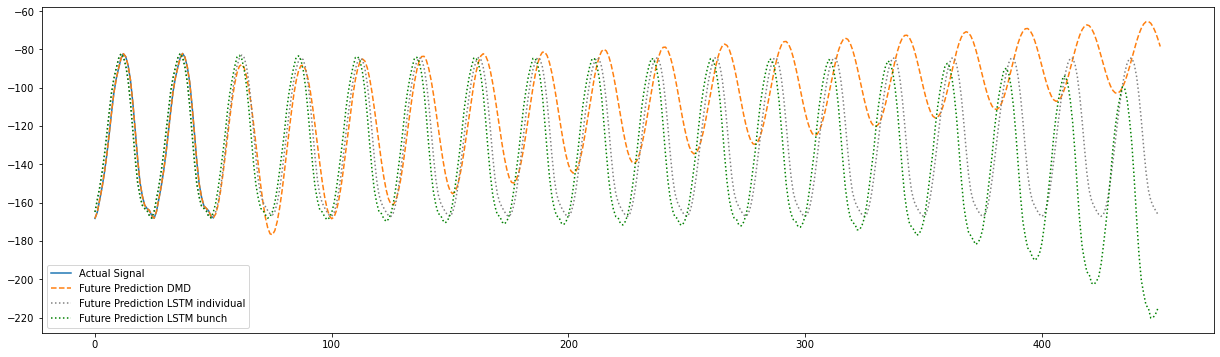

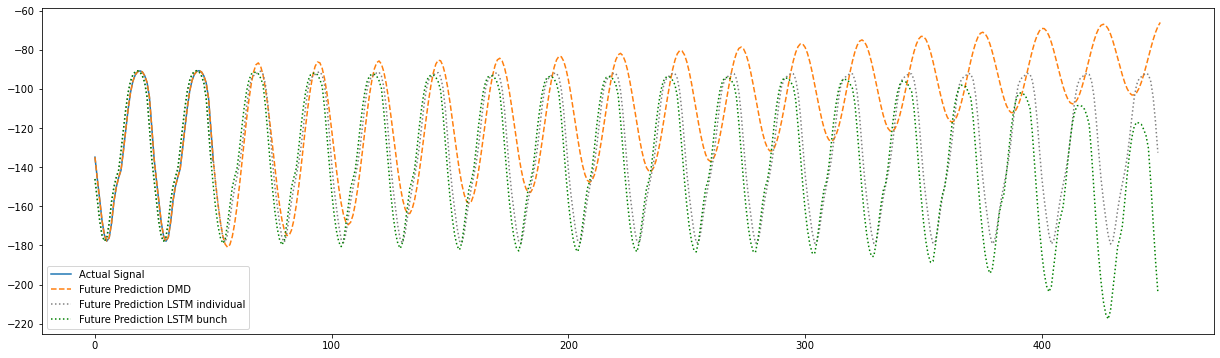

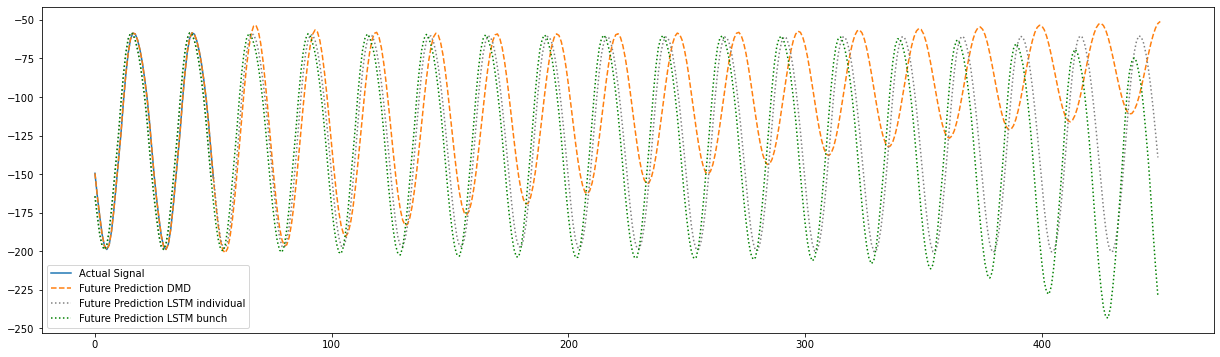

In [117]:
y_original=tf.transpose(y)
print("Original code",y_original.shape)

y_pred = np.array(y_pred)
pickle.dump(y_pred, open("./Temp_data_Case2/reconstructed_signals_dmd_"+str(encoding_dim)+".pkl", "wb"))

print("DMD predict",y_pred.shape)

seq_length=70
future_predictions_lstm=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", 'rb'))
print(future_predictions_lstm.shape)
future_predictions_lstm_reshape=np.reshape(future_predictions_lstm,(encoding_dim,-1))
print("LSTM predict",future_predictions_lstm_reshape.shape)
future_predictions_lstm_combine=np.transpose(np.vstack((np.transpose(y_original[:,400:]),np.transpose(future_predictions_lstm_reshape))))
print("LSTM predict&original",future_predictions_lstm_combine.shape)

future_latent_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", "rb")))
print(future_latent_predictions_lstm_bunch.shape)
print(y_original.shape)
future_predictions_lstm_combine_bunch=np.transpose(np.vstack((np.transpose(y_original[:,400:]),np.transpose(future_latent_predictions_lstm_bunch))))
print("LSTM predict_bunch&original",future_predictions_lstm_combine_bunch.shape)

# Plot the actual and predicted signals for the first signal as an example
for idx in range(y_original.shape[0]):
    plt.figure(figsize=(21, 6))
    plt.plot(y_original[idx, -(51):], label='Actual Signal')
    plt.plot(y_pred[idx, -(51+future_steps):], label='Future Prediction DMD', linestyle='dashed')
    plt.plot(future_predictions_lstm_combine[idx, -(50+future_steps):], label='Future Prediction LSTM individual', color='grey',linestyle='dotted')
    plt.plot(future_predictions_lstm_combine_bunch[idx, -(50+future_steps):], label='Future Prediction LSTM bunch', color='green',linestyle='dotted')
    plt.legend()
    plt.show()

In [4]:
#Reconstruct the code into the origin like array
def recontruction(ae,code):
    code_transp=np.transpose(code)
    x_ae=ae.decoder(code_transp)
    print(x_ae.shape)
    outputs=np.array(x_ae).reshape(code_transp.shape[0],55268,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case2data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case2data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))   
    return outputs

#Inverse scale the reconstructed data into the origin like array
def scalar_inverse(reconstructed_data):
    outputs=np.array(reconstructed_data).reshape(reconstructed_data.shape[0],55268,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case2data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case2data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))   
    return outputs 

#Calculat the magnitude of the velocity on x and y direction
def cal_Magnitude(data):
    three_dimension_data=np.array(data).transpose(1,2,0)

    two_dimension_data=np.zeros((three_dimension_data.shape[0], three_dimension_data.shape[2]), dtype=np.float32)
    #print(two_dimension_data.shape)
    for i in range(0, three_dimension_data.shape[0]):
        for j in range(0, three_dimension_data.shape[2]):
            magnitude=math.sqrt(pow(three_dimension_data[i,0,j],2)+pow(three_dimension_data[i,1,j],2))
            two_dimension_data[i][j]=magnitude
    two_dimension_data=two_dimension_data.reshape(two_dimension_data.shape[1],two_dimension_data.shape[0])
    return two_dimension_data

In [19]:
#Comparsion of reconstruction accuracy between SAE and POD in different code length
import joblib
import math
import numpy as np
import pickle

# start timer.
start_time = timeit.default_timer()

ori_data = np.load(open('./data/case2data/U.npy', 'rb'))[1201:1601]
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./Temp_data_Case2/ori_data3.pkl", "wb"))

rom_data_0=joblib.load(open("./Temp_data_Case2/reconstructed_data_7_POD.pkl", "rb"))[1201:1601]
rom_data_03=cal_Magnitude(scalar_inverse(rom_data_0))
pickle.dump(rom_data_03, open("./Temp_data_Case2/rom_data_03.pkl", "wb"))

rom_data_1=joblib.load(open("./Temp_data_Case2/reconstructed_data_12_POD.pkl", "rb"))[1201:1601]#
rom_data_13=cal_Magnitude(scalar_inverse(rom_data_1))
pickle.dump(rom_data_13, open("./Temp_data_Case2/rom_data_13.pkl", "wb"))

rom_data_2=joblib.load(open("./Temp_data_Case2/reconstructed_data_35_POD.pkl", "rb"))[1201:1601]
rom_data_23=cal_Magnitude(scalar_inverse(rom_data_2))
pickle.dump(rom_data_23, open("./Temp_data_Case2/rom_data_23.pkl", "wb"))

rom_data_3=joblib.load(open("./Temp_data_Case2/reconstructed_data_7_SAE.pkl", "rb"))[1201:1601]
rom_data_33=cal_Magnitude(scalar_inverse(rom_data_3))
pickle.dump(rom_data_33, open("./Temp_data_Case2/rom_data_33.pkl", "wb"))

rom_data_4=joblib.load(open("./Temp_data_Case2/reconstructed_data_12_SAE.pkl", "rb"))[1201:1601]
rom_data_43=cal_Magnitude(scalar_inverse(rom_data_4))
pickle.dump(rom_data_43, open("./Temp_data_Case2/rom_data_43.pkl", "wb"))

rom_data_5=joblib.load(open("./Temp_data_Case2/reconstructed_data_35_SAE.pkl", "rb"))[1201:1601]
rom_data_53=cal_Magnitude(scalar_inverse(rom_data_5))
pickle.dump(rom_data_53, open("./Temp_data_Case2/rom_data_53.pkl", "wb"))

print("time spend for prediction:",timeit.default_timer() - start_time)

(400, 55268, 2)


KeyboardInterrupt: 

In [24]:
ori_data2=joblib.load(open('./Temp_data_Case2/ori_data3.pkl', 'rb'))

rom_data_02=joblib.load(open('./Temp_data_Case2/rom_data_03.pkl', 'rb'))
rom_data_12=joblib.load(open('./Temp_data_Case2/rom_data_13.pkl', 'rb'))
rom_data_22=joblib.load(open('./Temp_data_Case2/rom_data_23.pkl', 'rb'))
rom_data_32=joblib.load(open('./Temp_data_Case2/rom_data_33.pkl', 'rb'))
rom_data_42=joblib.load(open('./Temp_data_Case2/rom_data_43.pkl', 'rb'))
rom_data_52=joblib.load(open('./Temp_data_Case2/rom_data_53.pkl', 'rb'))
from dmd_machine import Model_Processing_7inputs_2_SAE_POD as MP7

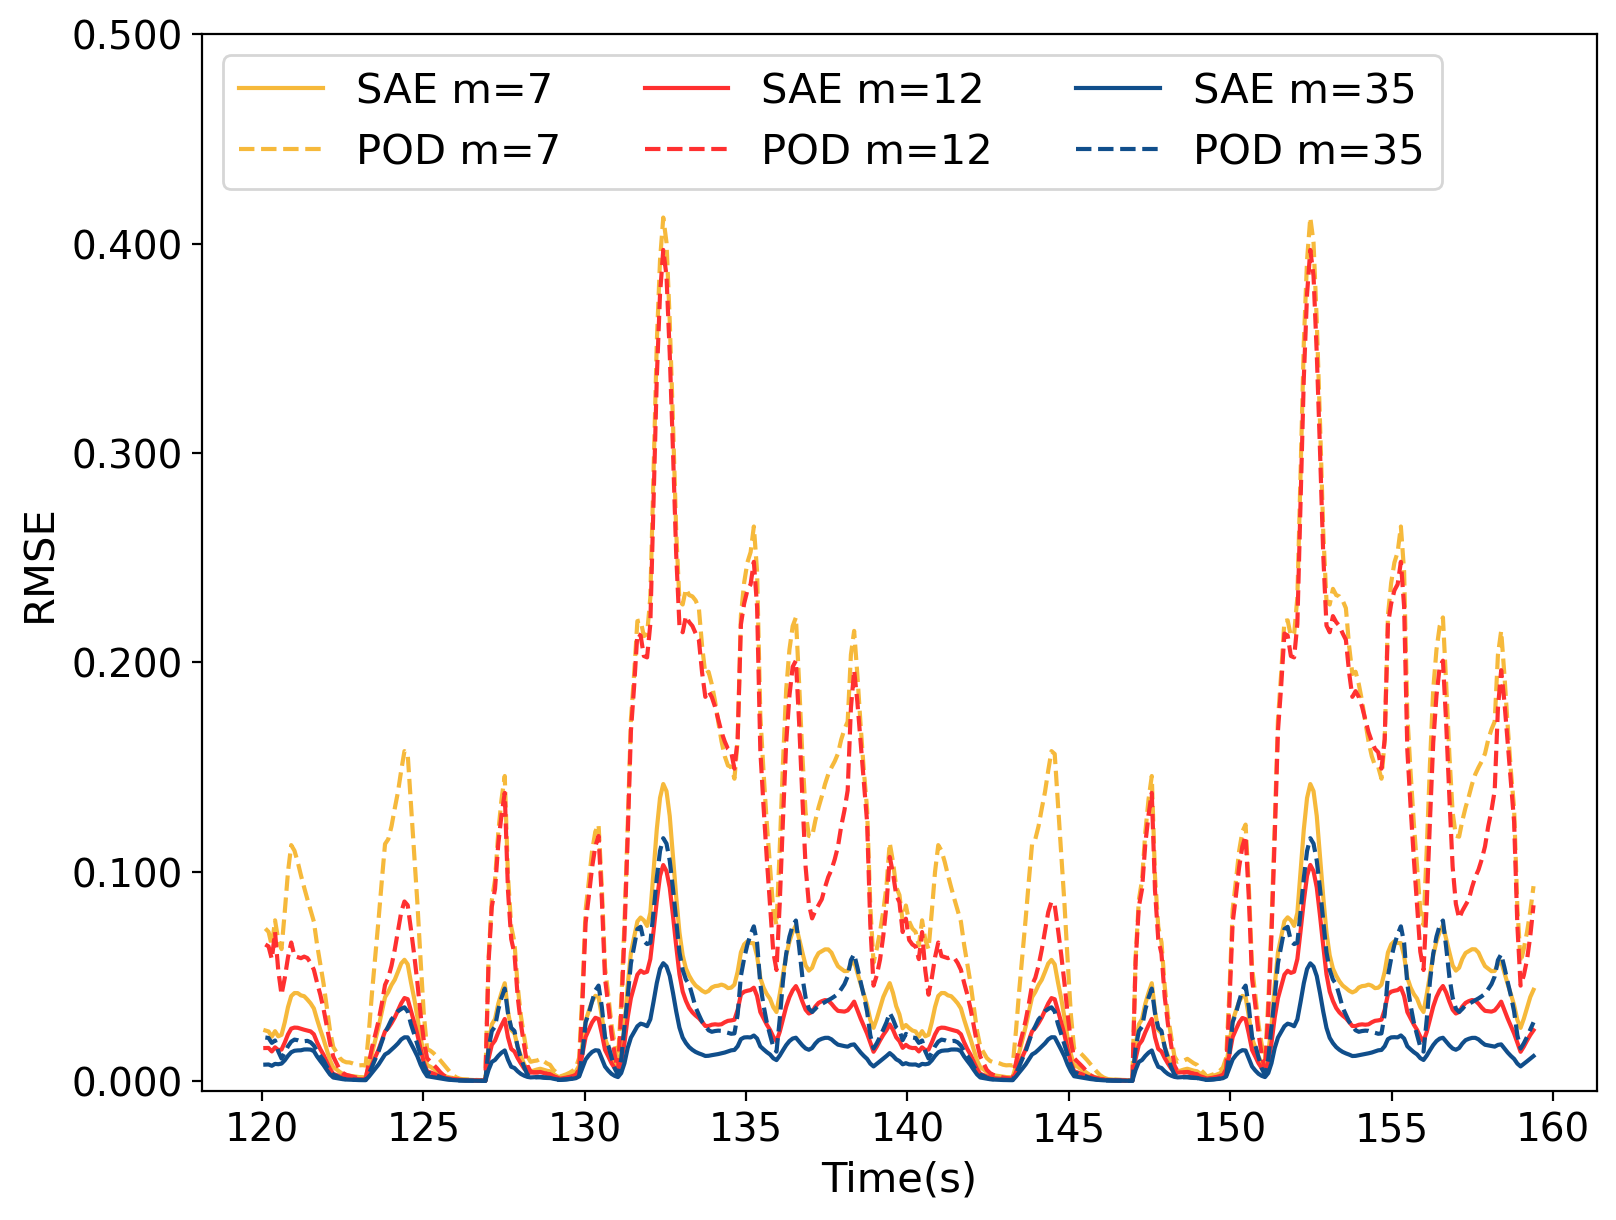

In [25]:
MP7.rmse_over_time(ori_data2, rom_data_32, rom_data_02,rom_data_42, rom_data_12,rom_data_52, rom_data_22,'U',0.5,120)

/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


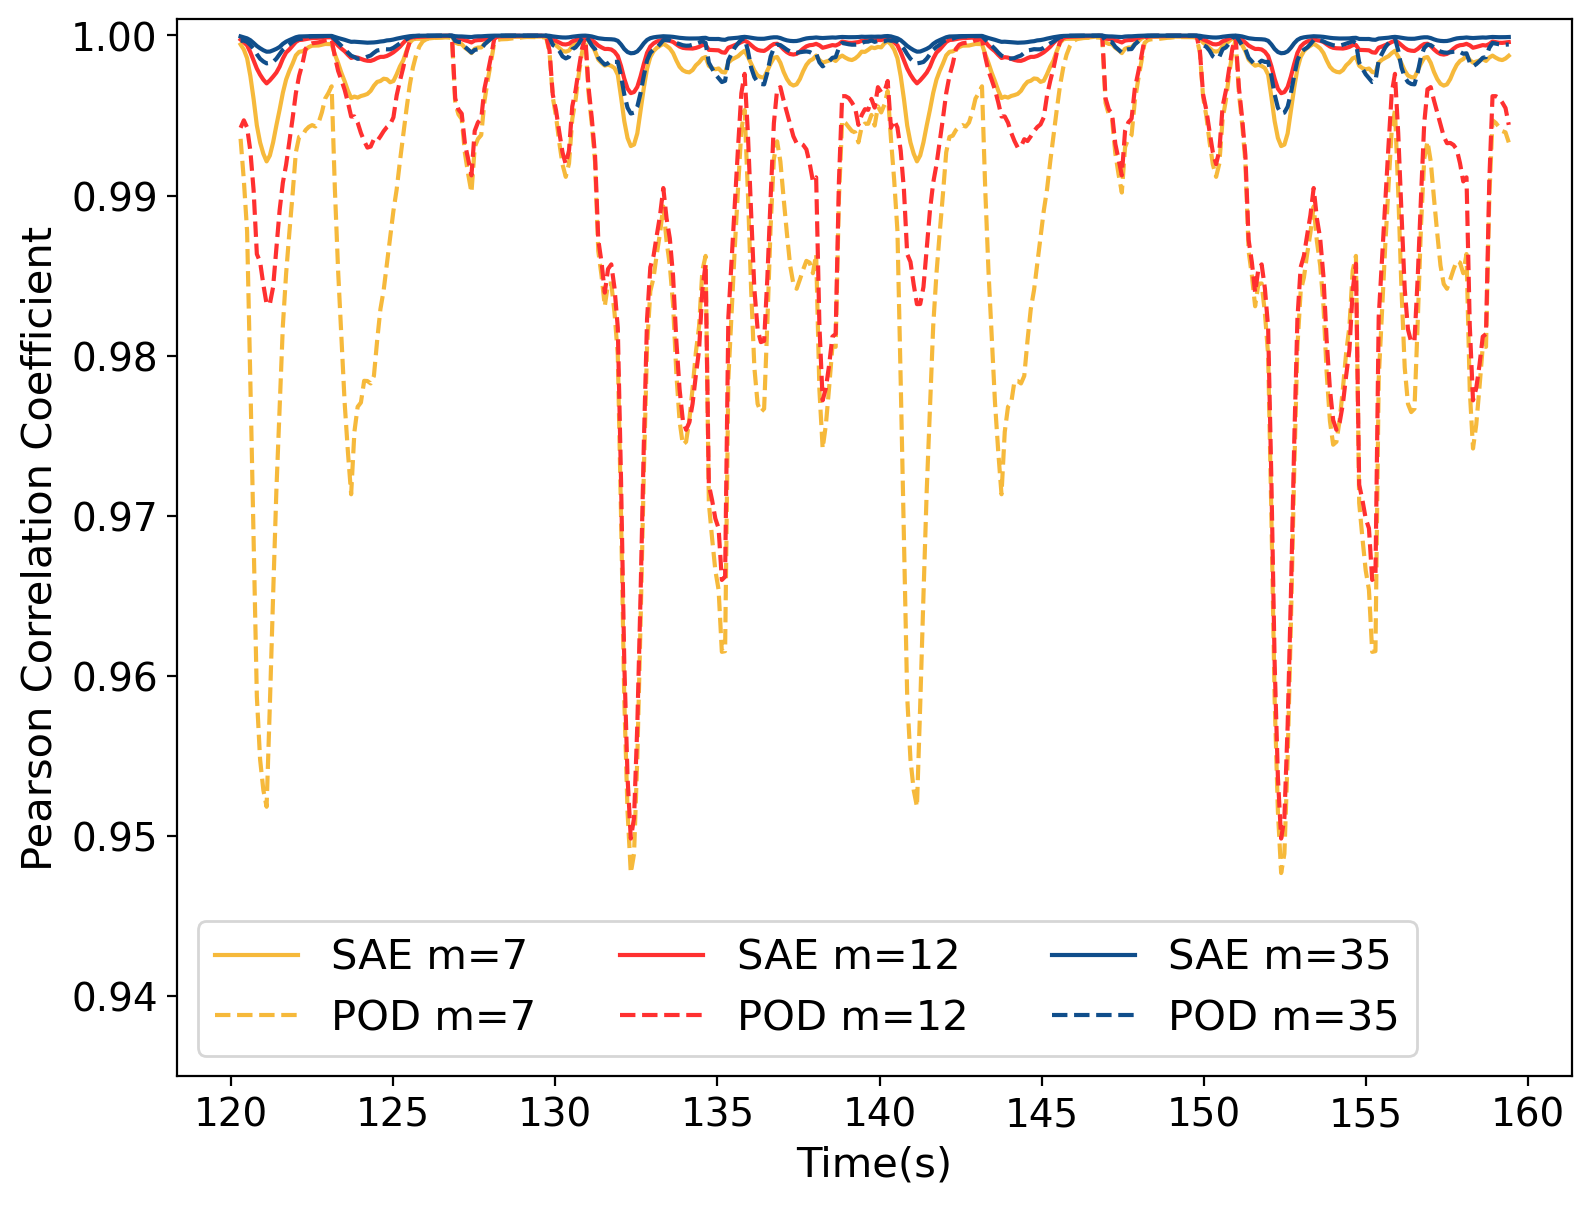

In [76]:
MP7.cc7(ori_data2, rom_data_32, rom_data_02,rom_data_42, rom_data_12,rom_data_52, rom_data_22,0.935,'U',120)

In [19]:
#Parametric study of the sequence length for training the LSTM-individual model
import joblib
import math
import numpy as np
import pickle
encoding_dim =12 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

print(np.load(open('./data/case2data/U.npy', 'rb')).shape)#[2001,55268, 2]
ori_data2=cal_Magnitude(np.load(open('./data/case2data/U.npy', 'rb'))[-400:])# 
print(ori_data2.shape)
pickle.dump(ori_data2, open("./Temp_data_Case2/ori_data2.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(10)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_10=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_10, open("./Temp_data_Case2/rom_data_individual_10.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(20)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_20=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_20, open("./Temp_data_Case2/rom_data_individual_20.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(30)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_30=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_30, open("./Temp_data_Case2/rom_data_individual_30.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(40)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_40=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_40, open("./Temp_data_Case2/rom_data_individual_40.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(50)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_50=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_50, open("./Temp_data_Case2/rom_data_individual_50.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(60)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_60=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_60, open("./Temp_data_Case2/rom_data_individual_60.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(70)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_70=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_70, open("./Temp_data_Case2/rom_data_individual_70.pkl", "wb"))

future_predictions_lstm_bunch=joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(80)+'_'+str(encoding_dim)+".pkl", 'rb')).squeeze()
print(future_predictions_lstm_bunch.shape)
rom_data_individual_80=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
pickle.dump(rom_data_individual_80, open("./Temp_data_Case2/rom_data_individual_80.pkl", "wb"))


(2001, 55268, 2)
(400, 55268)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)
(12, 400)
(400, 110536)


In [3]:
ori_data2=joblib.load(open("./Temp_data_Case2/ori_data2.pkl", 'rb'))
rom_data_individual_10=joblib.load(open("./Temp_data_Case2/rom_data_individual_10.pkl", 'rb'))
rom_data_individual_20=joblib.load(open("./Temp_data_Case2/rom_data_individual_20.pkl", 'rb'))
rom_data_individual_30=joblib.load(open("./Temp_data_Case2/rom_data_individual_30.pkl", 'rb'))
rom_data_individual_40=joblib.load(open("./Temp_data_Case2/rom_data_individual_40.pkl", 'rb'))
rom_data_individual_50=joblib.load(open("./Temp_data_Case2/rom_data_individual_50.pkl", 'rb'))
rom_data_individual_60=joblib.load(open("./Temp_data_Case2/rom_data_individual_60.pkl", 'rb'))
rom_data_individual_70=joblib.load(open("./Temp_data_Case2/rom_data_individual_70.pkl", 'rb'))
rom_data_individual_80=joblib.load(open("./Temp_data_Case2/rom_data_individual_80.pkl", 'rb'))    
from dmd_machine import Model_Processing_9inputs_2_seq_lenght as MP9
    

/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


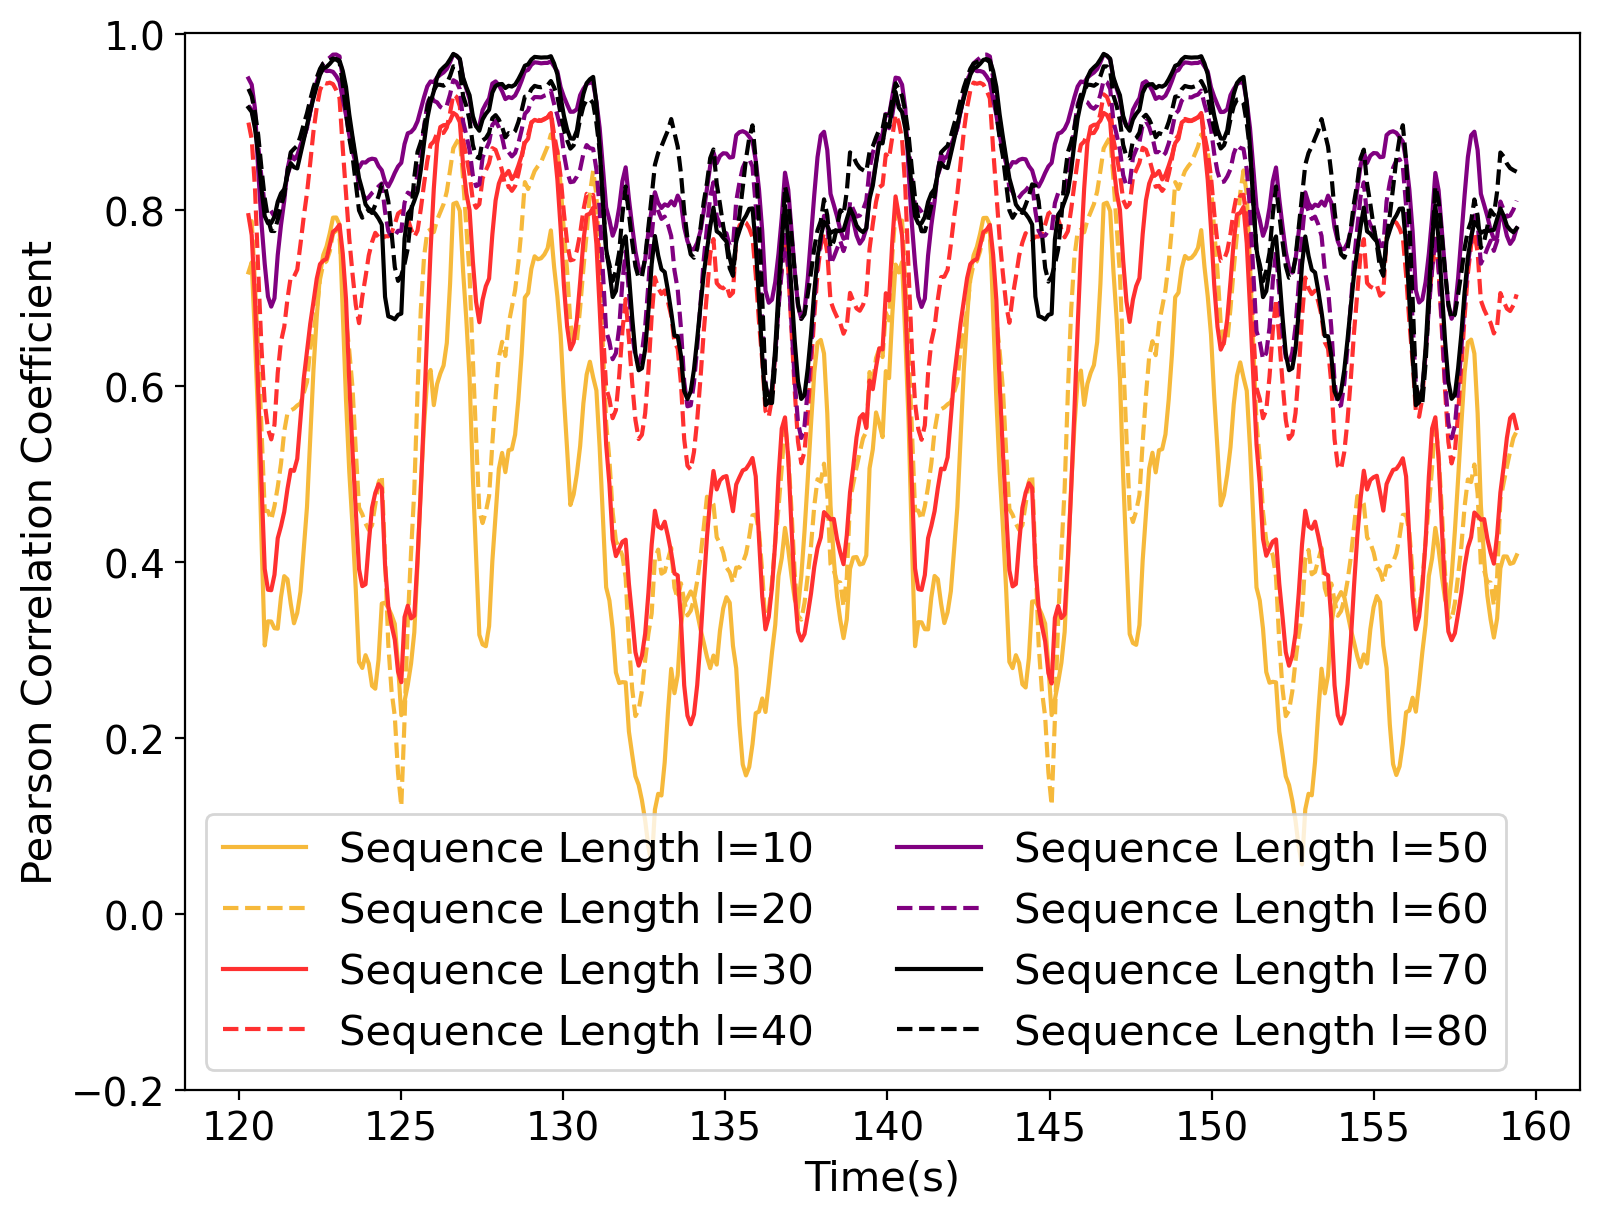

In [7]:
MP9.cc9(ori_data2, rom_data_individual_10, rom_data_individual_20, rom_data_individual_30, rom_data_individual_40,rom_data_individual_50, rom_data_individual_60,rom_data_individual_70, rom_data_individual_80,-0.2,'U',120,2)

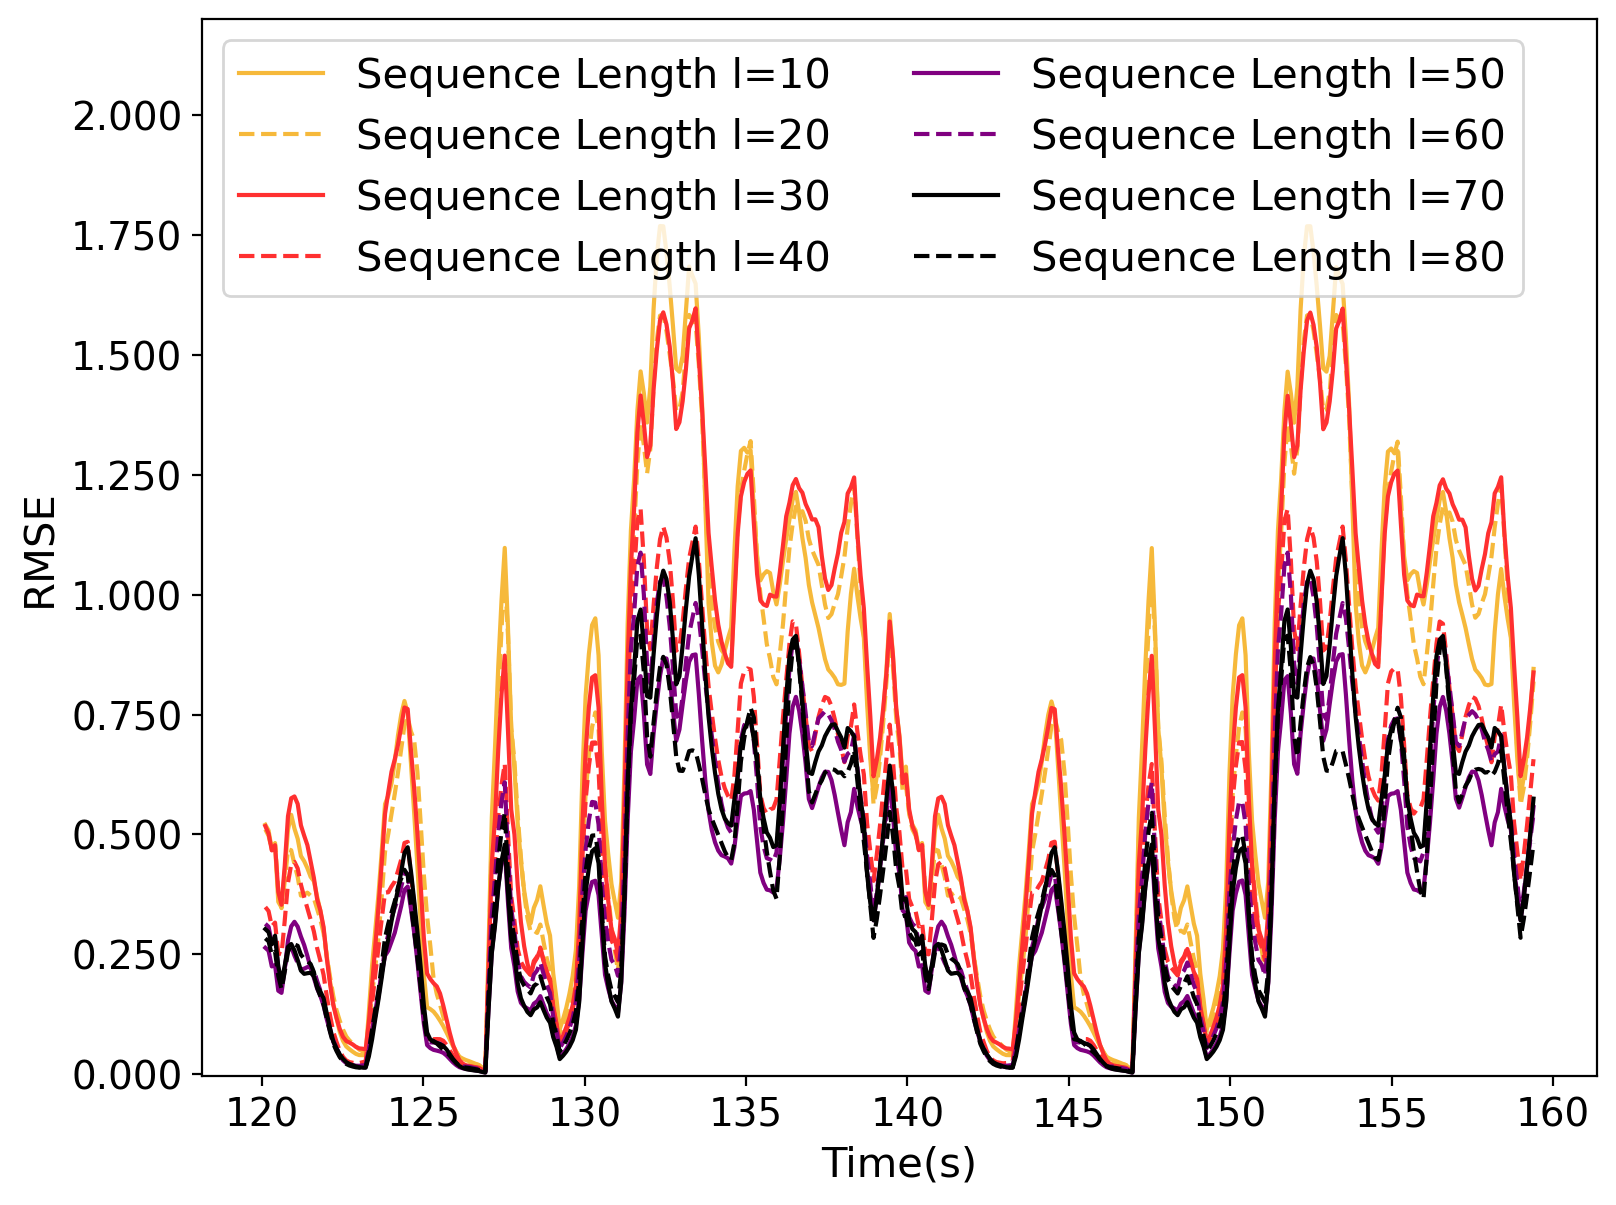

In [11]:
MP9.rmse_over_time(ori_data2, rom_data_individual_10, rom_data_individual_20, rom_data_individual_30, rom_data_individual_40,rom_data_individual_50, rom_data_individual_60,rom_data_individual_70, rom_data_individual_80,'U', 2.2, 120,2)

In [25]:
#Prediction comparison of three different models

import joblib
import pickle
print(np.load(open('./data/case2data/U.npy', 'rb')).shape)#[2001,55268, 2]
ori_data2=cal_Magnitude(np.load(open('./data/case2data/U.npy', 'rb'))[-400:])# 
print(ori_data2.shape)
pickle.dump(ori_data2, open("./Temp_data_Case2/ori_data2.pkl", "wb"))

seq_length=70

future_predictions_lstm_individual=(joblib.load(open("./Temp_data_Case2/future_predictions_lstm_individual_"+str(seq_length)+'_'+str(encoding_dim)+".pkl", 'rb'))).squeeze()
print(future_predictions_lstm_individual.shape)
rom_data_02=cal_Magnitude(recontruction(ae,future_predictions_lstm_individual[:,-400:]))
print(rom_data_02.shape)
pickle.dump(rom_data_02, open("./Temp_data_Case2/rom_data_02.pkl", "wb"))

y_pred=joblib.load(open("./Temp_data_Case2/reconstructed_signals_dmd_"+str(encoding_dim)+".pkl", 'rb'))
print(y_pred.shape)
rom_data_12=cal_Magnitude(recontruction(ae,y_pred[:,-400:]))#[:,-401:-1]  
print(rom_data_12.shape)
pickle.dump(rom_data_12, open("./Temp_data_Case2/rom_data_12.pkl", "wb"))

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_22=cal_Magnitude(recontruction(ae,future_predictions_lstm_bunch[:,-400:]))
print(rom_data_22.shape)
pickle.dump(rom_data_22, open("./Temp_data_Case2/rom_data_22.pkl", "wb"))
#

(2001, 55268, 2)
(400, 55268)
(35, 400)
(400, 110536)
(400, 55268)
(35, 1601)
(400, 110536)
(400, 55268)
(35, 400)
(400, 110536)
(400, 55268)


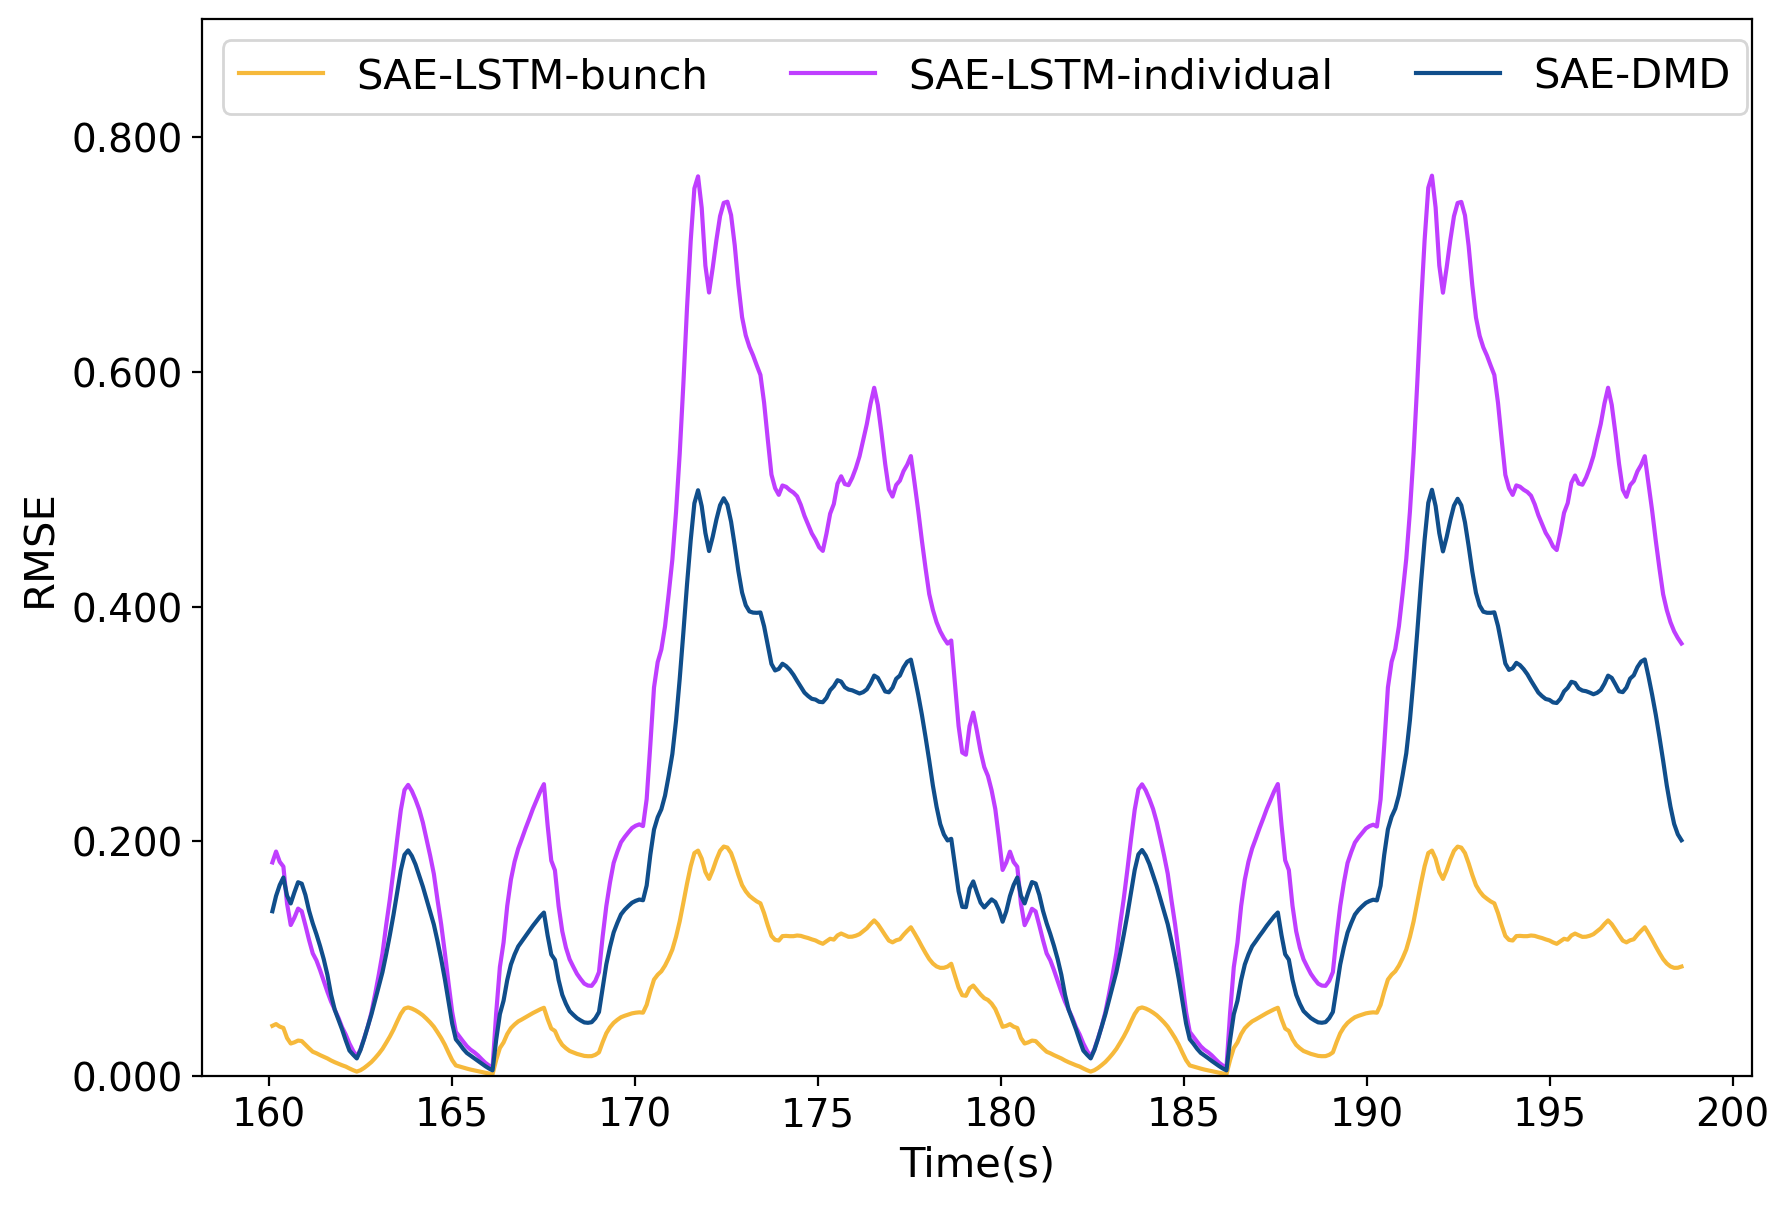

In [29]:
from dmd_machine import Model_Processing_4inputs_2 as MP4
ori_data2=joblib.load(open('./Temp_data_Case2/ori_data2.pkl', 'rb'))
rom_data_02=joblib.load(open('./Temp_data_Case2/rom_data_02.pkl', 'rb'))
rom_data_12=joblib.load(open('./Temp_data_Case2/rom_data_12.pkl', 'rb'))
rom_data_22=joblib.load(open('./Temp_data_Case2/rom_data_22.pkl', 'rb'))
MP4.rmse_over_time(ori_data2, rom_data_22, rom_data_02,rom_data_12,'U',0.9,160,'upper left',3)

/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/chuanhua/anaconda3/envs/venv_ROM/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


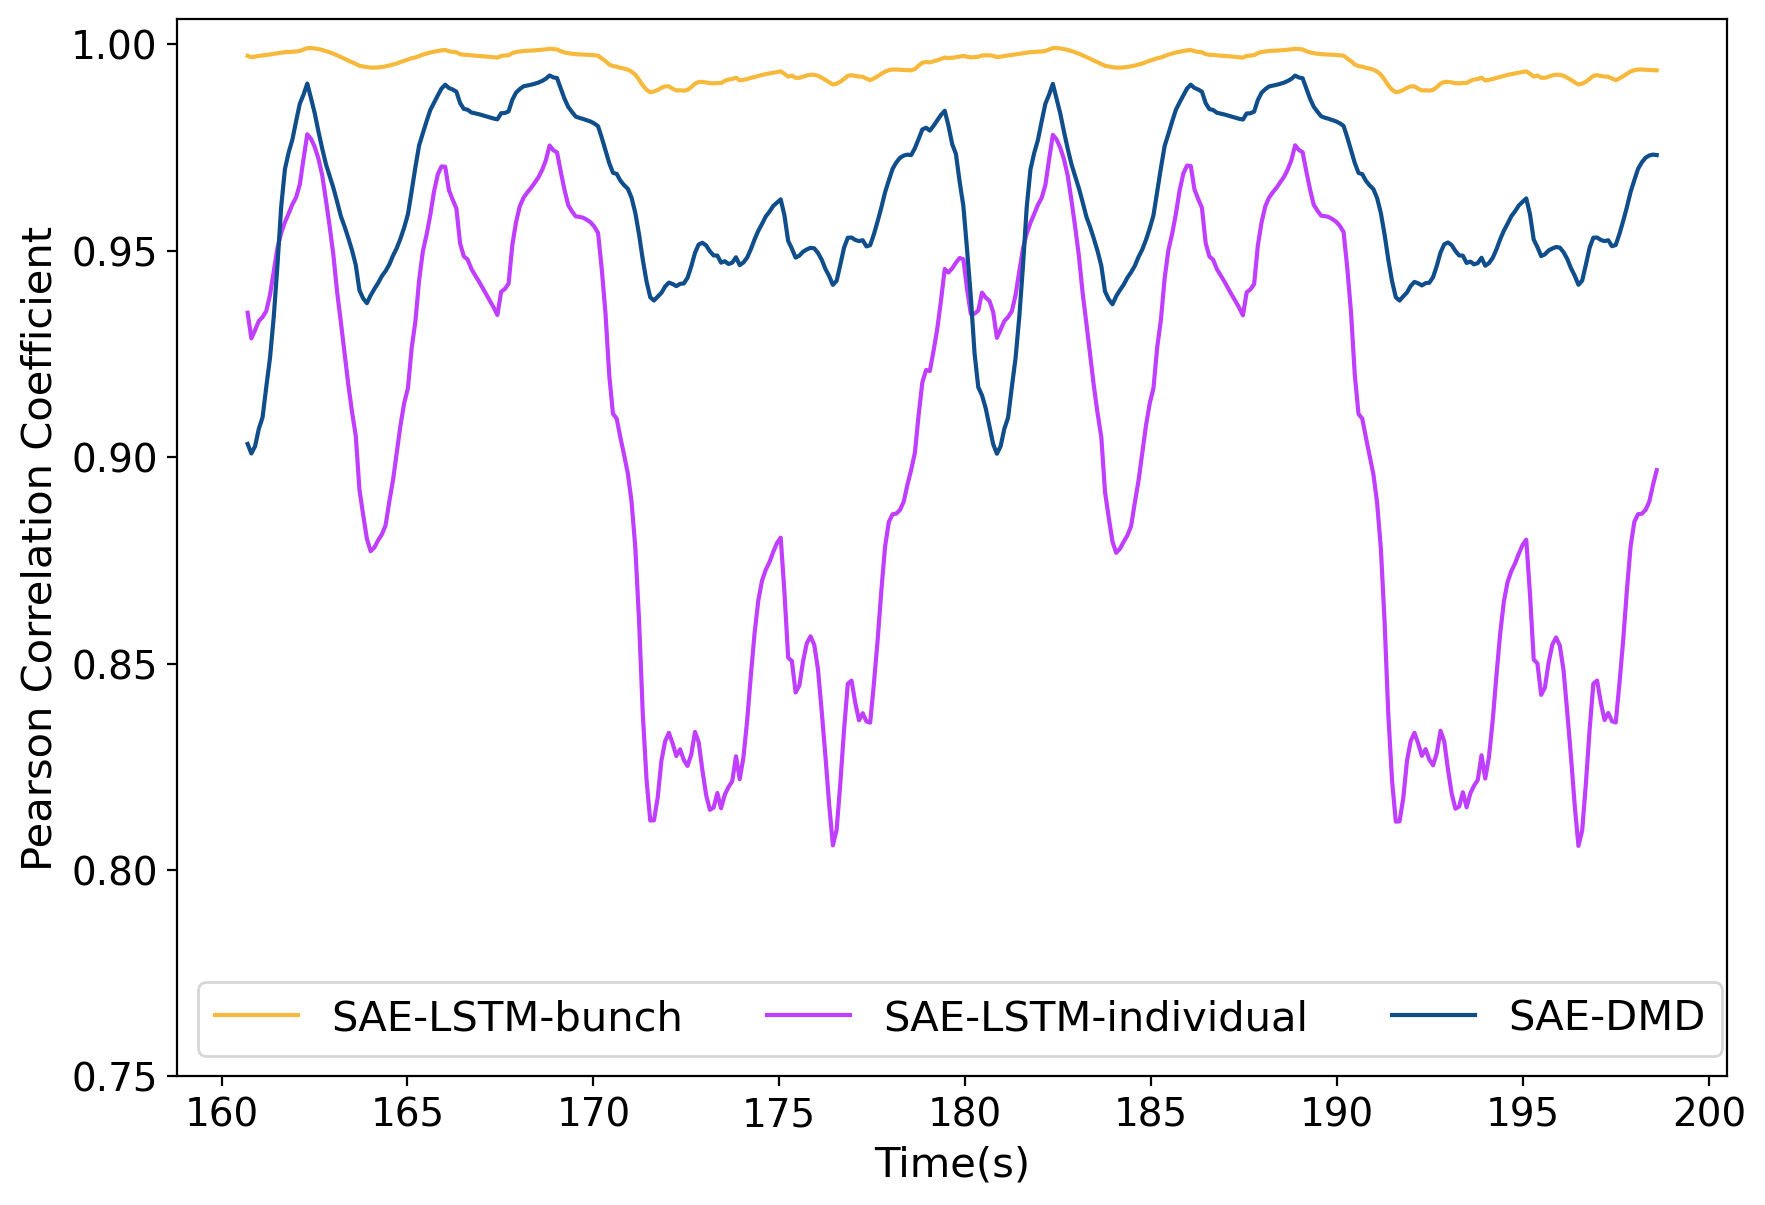

In [31]:
MP4.cc4(ori_data2, rom_data_22, rom_data_02,rom_data_12,0.75,'U',160,'lower left',3)

# ***Output***

In [33]:
#Output the point over time of various-lengthe SAE-LSTM-bunch model, and the selected point ID is 26621 in the following code snippets.
print(np.load(open('./data/case2data/U.npy', 'rb')).shape)#[2001,55268, 2]
ori_data2=np.load(open('./data/case2data/U.npy', 'rb'))[-400:]
pickle.dump(ori_data2, open("./Temp_data_Case2/ori_data2.pkl", "wb"))
ori_data02=cal_Magnitude(ori_data2)# 
print(ori_data02.shape)
pickle.dump(ori_data02, open("./Temp_data_Case2/ori_data02.pkl", "wb"))

encoding_dim =7 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_12=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_12, open("./Temp_data_Case2/rom_data_12.pkl", "wb"))
rom_data_22=cal_Magnitude(rom_data_12)
print(rom_data_22.shape)
pickle.dump(rom_data_22, open("./Temp_data_Case2/rom_data_22.pkl", "wb"))

encoding_dim =12 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_32=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_32, open("./Temp_data_Case2/rom_data_32.pkl", "wb"))
rom_data_42=cal_Magnitude(rom_data_32)
print(rom_data_42.shape)
pickle.dump(rom_data_42, open("./Temp_data_Case2/rom_data_42.pkl", "wb"))

encoding_dim =35 #[7,12,35]
model_save_folder = './AE_Models_case2'
encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model

ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

future_predictions_lstm_bunch=np.transpose(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_codes_"+str(encoding_dim)+".pkl", 'rb')))
print(future_predictions_lstm_bunch.shape)
rom_data_52=recontruction(ae,future_predictions_lstm_bunch[:,-400:])
pickle.dump(rom_data_52, open("./Temp_data_Case2/rom_data_52.pkl", "wb"))
rom_data_62=cal_Magnitude(rom_data_52)
print(rom_data_62.shape)
pickle.dump(rom_data_62, open("./Temp_data_Case2/rom_data_62.pkl", "wb"))


(2001, 55268, 2)
(400, 55268)
(7, 400)
(400, 110536)
(400, 55268)
(12, 400)
(400, 110536)
(400, 55268)
(35, 400)
(400, 110536)
(400, 55268)


In [5]:
ori_data2=joblib.load(open("./Temp_data_Case2/ori_data2.pkl", 'rb'))
ori_data02=joblib.load(open("./Temp_data_Case2/ori_data02.pkl", 'rb'))

rom_data_12=joblib.load(open("./Temp_data_Case2/rom_data_12.pkl", 'rb'))
rom_data_22=joblib.load(open("./Temp_data_Case2/rom_data_22.pkl", 'rb'))

rom_data_32=joblib.load(open("./Temp_data_Case2/rom_data_32.pkl", 'rb'))
rom_data_42=joblib.load(open("./Temp_data_Case2/rom_data_42.pkl", 'rb'))

rom_data_52=joblib.load(open("./Temp_data_Case2/rom_data_52.pkl", 'rb'))
rom_data_62=joblib.load(open("./Temp_data_Case2/rom_data_62.pkl", 'rb'))
from dmd_machine import Model_Processing_4inputs_2 as MP

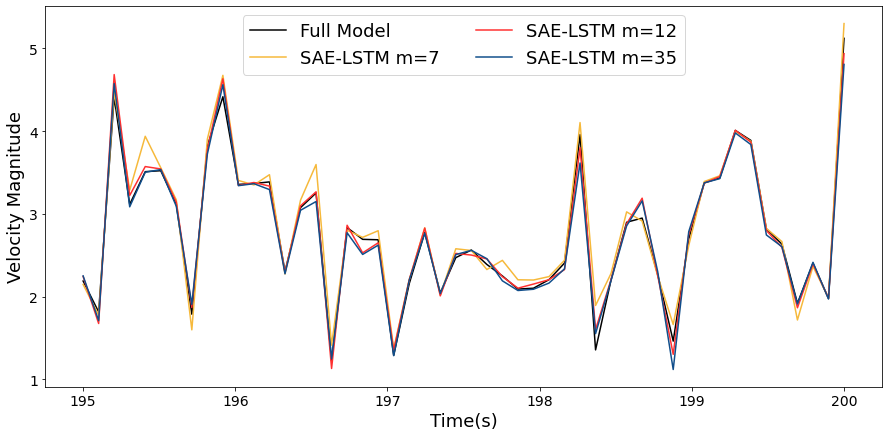

In [6]:
MP.point_over_time(ori_data02[-50:], rom_data_22[-50:], rom_data_42[-50:], rom_data_62[-50:],17126,'U',195,'upper center',2)

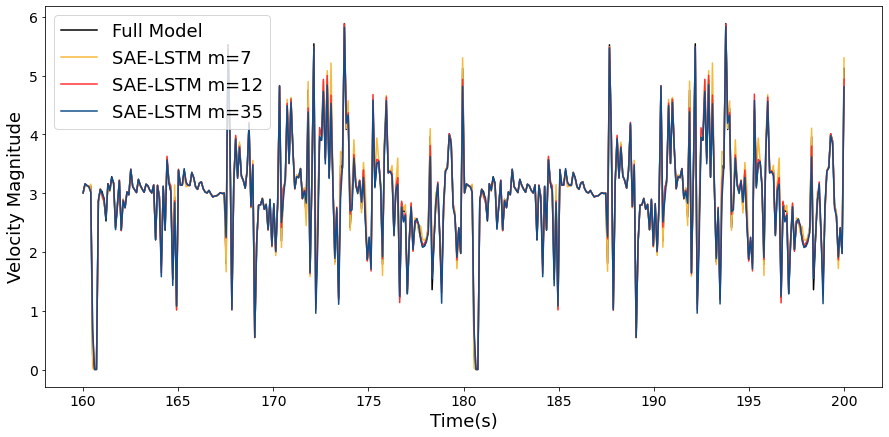

In [7]:
MP.point_over_time(ori_data02, rom_data_22, rom_data_42, rom_data_62,17126,'U',160,'upper left',1)

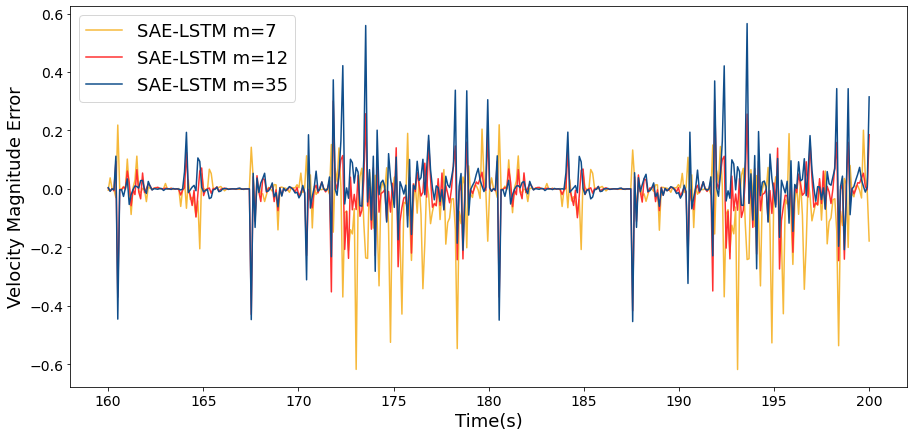

In [8]:
MP.point_over_time_error(ori_data02, rom_data_22, rom_data_42, rom_data_62,17126,'U',160,'upper left',1)

In [12]:
#Output the prediction results of SAE-LSTM-bunch model 
import numpy as np
import joblib
from dmd_machine import Model_Processing_5inputs_2 as MP
file_name = '/re2005w_'# name for each vtu file
field_name = 'U2'# name of selected field


In [16]:
encoding_dim=7#[7,12,35]

rom_data_1=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(encoding_dim)+".pkl", 'rb')))
print(rom_data_1.shape)
MP.transform_vector(rom_data_1, rom_data_1.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_'+str(encoding_dim),file_name, field_name)



(400, 55268, 2)
start to create the destination folder
start to store data as a new variable
transform succeed


In [17]:
rom_data_2=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(12)+".pkl", 'rb')))
print(rom_data_2.shape)
MP.transform_vector(rom_data_2, rom_data_2.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_'+str(12),file_name, field_name)

rom_data_3=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(35)+".pkl", 'rb')))
print(rom_data_3.shape)
MP.transform_vector(rom_data_3, rom_data_2.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_'+str(35),file_name, field_name)


(400, 55268, 2)
start to create the destination folder
start to store data as a new variable
transform succeed
(400, 55268, 2)
start to create the destination folder
start to store data as a new variable
transform succeed


# ***Errors***

In [19]:
#Output the errors between the predition of SAE-LSTM-bunch model and ground true snapshots
import joblib
import math
import numpy as np
import pickle

ori_data = np.load(open('./data/case2data/U.npy', 'rb'))[-400:]
print(ori_data.shape)

rom_data_0=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(7)+".pkl", 'rb')))

rom_data_1=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(12)+".pkl", 'rb')))

rom_data_2=scalar_inverse(joblib.load(open("./Temp_data_Case2/reconstructed_signals_lstm_bunch_"+str(35)+".pkl", 'rb')))

rom_error0=ori_data-rom_data_0
rom_error1=ori_data-rom_data_1
rom_error2=ori_data-rom_data_2


(400, 55268, 2)


In [21]:
import numpy as np
from dmd_machine import Model_Processing_5inputs_2 as MP
file_name = '/re2005w_'# name for each vtu file
field_name = 'Error'# name of selected field

MP.transform_vector(rom_error0, rom_data_0.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_error_'+str(7),file_name, field_name)
MP.transform_vector(rom_error1, rom_data_1.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_error_'+str(12),file_name, field_name)
MP.transform_vector(rom_error2, rom_data_2.shape[0], './data/case2data/VTU_forOutput', './Temp_data_Case2/LSTM_bunch_error_'+str(35),file_name, field_name)



start to create the destination folder
start to store data as a new variable
transform succeed
start to create the destination folder
start to store data as a new variable
transform succeed
start to create the destination folder
start to store data as a new variable
transform succeed
